# Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from matplotlib.colors import Normalize
import networkx as nx
from scipy.signal import welch
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA

# Baselines

In [2]:
def scale_spectral_radius(W, target_radius=0.95):
    """
    Scales a matrix W so that its largest eigenvalue magnitude = target_radius.
    """
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

def augment_state_with_squares(x):
    """
    Given state vector x in R^N, return [ x, x^2, 1 ] in R^(2N+1).
    We'll use this for both training and prediction.
    """
    x_sq = x**2
    return np.concatenate([x, x_sq, [1.0]])  # shape: 2N+1

### Baseline ESN

In [3]:
class ESN3D:
    """
    Dense random ESN for 3D->3D single-step.
    Teacher forcing for training, autoregressive for testing.
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W = np.random.randn(reservoir_size, reservoir_size)*0.1
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale
        # self.W_in = np.random.uniform(-self.input_scale, self.input_scale, (reservoir_size, 3))

        self.W_out = None
        self.x = np.zeros(reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])

        # polynomial readout
        X_list = []
        for s in states_use:
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)  # shape => [T-discard, 2N+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)


### SCR

In [4]:
class CR3D:
    """
    Cycle (ring) reservoir for 3D->3D single-step,
    teacher forcing for training, autoregressive for testing.
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W[i, j] = 1.0
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W
        
        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale

        self.W_out = None
        self.x = np.zeros(reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])

        # polynomial readout
        X_list = []
        for s in states_use:
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)  # shape => [T-discard, 2N+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)


### CRJ

In [5]:
class CRJ3D:
    """
    Cycle Reservoir with Jumps (CRJ) for 3D->3D single-step tasks.
    We form a ring adjacency with an extra 'jump' edge in each row.
    This can help capture multiple timescales or delayed memory
    while retaining the easy ring structure.

    The adjacency is built as follows (reservoir_size = mod N):
      For each i in [0..N-1]:
        W[i, (i+1) % mod N] = 1.0
        W[i, (i+jump) % mod N] = 1.0
    Then we scale by 'spectral_radius.' We do an ESN update
    with readout [ x, x^2, 1 ] -> next step in R^3.
    """

    def __init__(self,
                 reservoir_size=300,
                 jump=10,                # offset for the jump
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        reservoir_size: how many nodes in the ring
        jump            : the offset for the 2nd connection from node i
        spectral_radius : scale adjacency
        input_scale     : scale factor for W_in
        leaking_rate    : ESN 'alpha'
        ridge_alpha     : ridge penalty for readout
        seed            : random seed
        """
        self.reservoir_size = reservoir_size
        self.jump = jump
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        # build adjacency
        np.random.seed(self.seed)
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            # cycle edge: i -> (i+1)%N
            W[i, (i+1) % reservoir_size] = 1.0
            # jump edge: i -> (i+jump)%N
            W[i, (i + self.jump) % reservoir_size] = 1.0

        # scale spectral radius
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        # input weights => shape [N,3]
        np.random.seed(self.seed+100)
        W_in = (np.random.rand(reservoir_size, 3) - 0.5)*2.0*self.input_scale
        self.W_in = W_in

        # readout
        self.W_out = None
        self.x = np.zeros(self.reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Single-step ESN update:
          x(t+1) = (1-alpha)*x(t) + alpha*tanh( W x(t) + W_in u(t) )
        """
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        """
        Teacher forcing => feed the real 3D inputs => gather states.
        Return (states_after_discard, states_discarded).
        """
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        """
        gather states => polynomial readout => solve ridge
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]
        X_list = []
        for s in states_use:
            # polynomial expansion => [ x, x^2, 1 ]
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        self.W_out = reg.coef_  # shape => (3, 2N+1)

    def predict_autoregressive(self, initial_input, n_steps):
        """
        fully autoregressive => feed last output => next input
        """
        preds = []
        #self.reset_state()
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            big_x = augment_state_with_squares(self.x)
            out = self.W_out @ big_x  # shape => (3,)
            preds.append(out)
            current_in = out
        return np.array(preds)
        
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

# SparseESN

In [6]:
class SparseESN3D:
    """
    Sparse random ESN for 3D->3D single-step,
    teacher forcing for training, autoregressive for testing.
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 connectivity=0.05,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W_full = np.random.randn(reservoir_size, reservoir_size)*0.1
        mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
        W = W_full * mask
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed+1)
        self.W_in = (np.random.rand(reservoir_size,3) - 0.5)*2.0*self.input_scale

        self.W_out = None
        self.x = np.zeros(reservoir_size)

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0],1))])

        # polynomial readout
        X_list = []
        for s in states_use:
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)  # shape => [T-discard, 2N+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
            current_in = out
        return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

### Small-World Res

In [7]:
# # --- Revised segregated IO reservoir class ---
# class SW3DSegregated:
#     """
#     Segregated IO small-world reservoir with spatial embedding.
    
#     The reservoir is partitioned into three segments:
#       - Input group: nodes that receive external input.
#       - Core group: intermediate hidden nodes.
#       - Output group: nodes from which the readout is taken.
    
#     Total nodes = 500:
#       - 100 Input nodes are clustered (angles in [-delta, delta])
#       - 100 Output nodes are clustered (angles in [pi-delta, pi+delta])
#       - 300 Core nodes are distributed evenly over the remaining circle.
    
#     Connectivity is generated over the sorted order (by angular position) using
#     a regular ring (nearest neighbor) scheme with random rewiring (Watts–Strogatz style).
#     """
#     def __init__(self,
#                  reservoir_size=500,
#                  edges_per_node=6,            # Must be even (here 6: 3 forward, 3 backward)
#                  input_reservoir_size=100,      # Number of input nodes
#                  output_reservoir_size=100,     # Number of output nodes
#                  rewiring_probability=0.1,
#                  spectral_radius=0.95,
#                  input_scale=1.0,
#                  leaking_rate=1.0,
#                  ridge_alpha=1e-6,
#                  seed=48):
#         # Save parameters
#         self.reservoir_size = reservoir_size
#         self.edges_per_node = edges_per_node
#         self.input_res_size = input_reservoir_size
#         self.output_res_size = output_reservoir_size
#         self.core_res_size = reservoir_size - (input_reservoir_size + output_reservoir_size)
#         self.rewiring_probability = rewiring_probability
#         self.spectral_radius = spectral_radius
#         self.input_scale = input_scale
#         self.leaking_rate = leaking_rate
#         self.ridge_alpha = ridge_alpha
#         self.seed = seed
        
#         np.random.seed(self.seed+1)
        
#         # --- Assign spatial positions to nodes (angular embedding on a circle) ---
#         # Define width for the input/output clusters.
#         delta = np.pi / 20  # small angular window (≈9°)
#         n_in = self.input_res_size
#         n_out = self.output_res_size
#         n_core = self.core_res_size
        
#         # Input nodes: angles uniformly in [-delta, delta]
#         input_positions = np.random.uniform(-delta, delta, size=n_in)
#         # Output nodes: angles uniformly in [pi-delta, pi+delta]
#         output_positions = np.random.uniform(np.pi - delta, np.pi + delta, size=n_out)
        
#         # Core nodes: distribute them evenly over the remaining parts of the circle.
#         # For clarity, we divide the remainder into two arcs.
#         n_core1 = n_core // 2
#         n_core2 = n_core - n_core1
#         # Arc 1: from delta to (pi - delta)
#         core_positions1 = np.linspace(delta, np.pi - delta, n_core1, endpoint=False)
#         # Arc 2: from (pi + delta) to (2*pi - delta)
#         core_positions2 = np.linspace(np.pi + delta, 2*np.pi - delta, n_core2, endpoint=False)
#         core_positions = np.concatenate([core_positions1, core_positions2])
        
#         # Concatenate all positions and assign labels:
#         # 0 for input; 1 for core; 2 for output.
#         self.positions = np.concatenate([input_positions, core_positions, output_positions])
#         self.labels = np.concatenate([np.zeros(n_in, dtype=int),
#                                        np.ones(n_core, dtype=int),
#                                        2*np.ones(n_out, dtype=int)])
        
#         # Sort nodes by angular position so they lie along a ring.
#         sort_order = np.argsort(self.positions)
#         self.positions = self.positions[sort_order]
#         self.labels = self.labels[sort_order]
#         self.all_indices = np.arange(self.reservoir_size)
        
#         # Determine indices for each group after sorting.
#         self.input_indices = np.where(self.labels == 0)[0]
#         self.core_indices = np.where(self.labels == 1)[0]
#         self.output_indices = np.where(self.labels == 2)[0]
        
#         # --- Create input weight matrix (applied only to input nodes) ---
#         # Assuming external input is 3-dimensional.
#         self.W_in = (np.random.rand(len(self.input_indices), 3) - 0.5) * self.input_scale
        
#         # Initialize output weight (readout) and reservoir state vector.
#         self.W_out = None
#         self.x = np.zeros(self.reservoir_size)
        
#         # --- Build reservoir connectivity using the sorted (ring) order ---
#         # We use a simple ring-based connection: for each node, connect to its
#         # nearest neighbors (with offsets 1 to edges_per_node/2) in each direction.
#         W = np.zeros((self.reservoir_size, self.reservoir_size))
#         half_edges = self.edges_per_node // 2
#         for i in range(self.reservoir_size):
#             for offset in range(1, half_edges + 1):
#                 j = (i + offset) % self.reservoir_size
#                 k = (i - offset) % self.reservoir_size
#                 W[i, j] = 1.0
#                 W[i, k] = 1.0
        
#         # --- Apply random rewiring (Watts–Strogatz) across all nodes ---
#         for i in range(self.reservoir_size):
#             current_neighbors = np.where(W[i] == 1.0)[0]
#             for j in current_neighbors:
#                 if np.random.rand() < self.rewiring_probability:
#                     W[i, j] = 0.0
#                     # Ensure new connection does not duplicate an existing link
#                     possible_nodes = list(set(self.all_indices) - {i} - set(np.where(W[i] == 1.0)[0]))
#                     if possible_nodes:
#                         new_j = np.random.choice(possible_nodes)
#                         W[i, new_j] = 1.0
                        
#         # Scale the reservoir connectivity to have the desired spectral radius.
#         self.W = scale_spectral_radius(W, self.spectral_radius)

#     def reset_state(self):
#         self.x = np.zeros(self.reservoir_size)

#     def _update(self, u):
#         """
#         Update the reservoir state vector x.
#           - The recurrent contribution is computed via W @ x.
#           - The external input u (a 3D vector) is added only to input nodes (via W_in).
#           - A tanh nonlinearity and leaky integration are applied.
#         """
#         recurrent = self.W @ self.x
#         ext_input = np.zeros(self.reservoir_size)
#         # Apply external input only to nodes in the input group.
#         for idx, node in enumerate(self.input_indices):
#             ext_input[node] = self.W_in[idx] @ u
#         pre_activation = recurrent + ext_input
#         x_new = np.tanh(pre_activation)
#         alpha = self.leaking_rate
#         self.x = (1.0 - alpha) * self.x + alpha * x_new

#     def collect_states(self, inputs, discard=100):
#         """
#         Run the reservoir over an input sequence.
#           - The external input drives only the input nodes.
#           - States from the output nodes are recorded (after a washout period).
#         Returns:
#           - output_states: a T x (# output nodes) array (post-discard).
#           - discard_states: states corresponding to the washout period.
#         """
#         self.reset_state()
#         all_states = []
#         for u in inputs:
#             self._update(u)
#             all_states.append(self.x.copy())
#         all_states = np.array(all_states)
#         output_states = all_states[:, self.output_indices]
#         return output_states[discard:], output_states[:discard]

#     def fit_readout(self, train_input, train_target, discard=100):
#         """
#         Train the linear readout on teacher-forced reservoir states.
#         Only states from the output nodes (the segregated readout cluster)
#         are used. A polynomial (squares) expansion and a bias term are
#         applied before ridge regression.
#         """
#         states_use, _ = self.collect_states(train_input, discard=discard)
#         targets_use = train_target[discard:]
#         X_list = [augment_state_with_squares(s) for s in states_use]
#         X_aug = np.array(X_list)  # Shape: [T-discard, 2*len(output_indices) + 1]
#         reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
#         reg.fit(X_aug, targets_use)
#         self.W_out = reg.coef_

#     def predict_autoregressive(self, initial_input, n_steps):
#         """
#         Generate predictions in closed-loop (autoregressive) mode.
#           - At each step, update the reservoir.
#           - Compute the readout using only the output node states.
#           - The prediction becomes the next input.
#         """
#         preds = []
#         current_in = np.array(initial_input)
#         for _ in range(n_steps):
#             self._update(current_in)
#             x_out = self.x[self.output_indices]
#             x_aug = augment_state_with_squares(x_out)
#             out = self.W_out @ x_aug
#             preds.append(out)
#             current_in = out
#         return np.array(preds)
    
#     def predict_open(self, test_input):
#         preds = []
#         for u in test_input:
#             self._update(u)
#             x_out = self.x[self.output_indices]
#             x_aug = augment_state_with_squares(x_out)
#             out = self.W_out @ x_aug
#             preds.append(out)
#         return np.array(preds)


# # --- Random IO Reservoir Class ---
# class SW3DRandom:
#     """
#     Random IO small-world reservoir for 3D->3D mapping.
    
#     In this version:
#       - Total reservoir nodes: reservoir_size (default 500)
#       - Input nodes: a subset of reservoir nodes (default 100) chosen at random.
#       - Output nodes: a disjoint subset of reservoir nodes (default 100) chosen at random.
#       - The remaining nodes (core nodes) are the other 300 nodes.
    
#     The recurrent connectivity is created using a ring-based nearest-neighbor scheme (with edges_per_node
#     number of connections per node) and then rewired randomly with a given rewiring probability.
    
#     The external input (assumed 3-dimensional) is injected only on the input nodes (via W_in),
#     and the output is read only from the output nodes.
#     """
#     def __init__(self,
#                  reservoir_size=500,
#                  edges_per_node=6,              # Must be even (here: 3 neighbors forward, 3 backward)
#                  input_reservoir_size=100,        # Number of input nodes
#                  output_reservoir_size=100,       # Number of output nodes
#                  rewiring_probability=0.1,
#                  spectral_radius=0.95,
#                  input_scale=1.0,
#                  leaking_rate=1.0,
#                  ridge_alpha=1e-6,
#                  seed=48):
#         # Save parameters
#         self.reservoir_size = reservoir_size
#         self.edges_per_node = edges_per_node
#         self.input_res_size = input_reservoir_size
#         self.output_res_size = output_reservoir_size
#         self.core_res_size = reservoir_size - (input_reservoir_size + output_reservoir_size)
#         self.rewiring_probability = rewiring_probability
#         self.spectral_radius = spectral_radius
#         self.input_scale = input_scale
#         self.leaking_rate = leaking_rate
#         self.ridge_alpha = ridge_alpha
#         self.seed = seed

#         np.random.seed(self.seed+1)
#         total_indices = np.arange(self.reservoir_size)
#         # Randomly choose indices for IO nodes without overlapping.
#         all_io = np.random.choice(total_indices, size=(self.input_res_size + self.output_res_size), replace=False)
#         np.random.shuffle(all_io)
#         self.input_indices = all_io[:self.input_res_size]
#         self.output_indices = all_io[self.input_res_size:self.input_res_size + self.output_res_size]
#         # The core indices are the remaining ones
#         self.core_indices = np.array(list(set(total_indices) - set(self.input_indices) - set(self.output_indices)))
        
#         # --- Create Input Weight Matrix ---
#         # Only input nodes receive external input; input is assumed 3-dimensional.
#         self.W_in = (np.random.rand(len(self.input_indices), 3) - 0.5) * self.input_scale

#         # Initialize output weight (readout) and reservoir state vector.
#         self.W_out = None
#         self.x = np.zeros(self.reservoir_size)
        
#         # --- Build reservoir connectivity ---
#         # Use a ring-based connectivity in the natural (index) order.
#         # Each node i will be connected to its nearest half_edges neighbors in both directions.
#         W = np.zeros((self.reservoir_size, self.reservoir_size))
#         half_edges = self.edges_per_node // 2
#         for i in range(self.reservoir_size):
#             for offset in range(1, half_edges + 1):
#                 j = (i + offset) % self.reservoir_size
#                 k = (i - offset) % self.reservoir_size
#                 W[i, j] = 1.0
#                 W[i, k] = 1.0

#         # --- Random rewiring (Watts-Strogatz style) ---
#         for i in range(self.reservoir_size):
#             current_neighbors = np.where(W[i] == 1.0)[0]
#             for j in current_neighbors:
#                 if np.random.rand() < self.rewiring_probability:
#                     W[i, j] = 0.0
#                     possible_nodes = list(set(range(self.reservoir_size)) - {i} - set(np.where(W[i] == 1.0)[0]))
#                     if possible_nodes:
#                         new_j = np.random.choice(possible_nodes)
#                         W[i, new_j] = 1.0

#         # Scale the reservoir weight matrix to have the desired spectral radius.
#         self.W = scale_spectral_radius(W, self.spectral_radius)
    
#     def reset_state(self):
#         self.x = np.zeros(self.reservoir_size)
    
#     def _update(self, u):
#         """
#         Update the reservoir state.
#           - The recurrent input is W @ x.
#           - External input u (3D) is added only at input nodes.
#           - A tanh nonlinearity and leaky integration update the state.
#         """
#         recurrent = self.W @ self.x
#         ext_input = np.zeros(self.reservoir_size)
#         for idx, node in enumerate(self.input_indices):
#             ext_input[node] = self.W_in[idx] @ u
#         pre_activation = recurrent + ext_input
#         x_new = np.tanh(pre_activation)
#         alpha = self.leaking_rate
#         self.x = (1.0 - alpha) * self.x + alpha * x_new
    
#     def collect_states(self, inputs, discard=100):
#         """
#         Drive the reservoir with a sequence of inputs and record the states.
#         Only the states of the output nodes are kept for the readout.
#         """
#         self.reset_state()
#         all_states = []
#         for u in inputs:
#             self._update(u)
#             all_states.append(self.x.copy())
#         all_states = np.array(all_states)
#         output_states = all_states[:, self.output_indices]
#         return output_states[discard:], all_states[:discard]
    
#     def fit_readout(self, train_input, train_target, discard=100):
#         """
#         Train the readout weights from the reservoir.
#           - The readout is based on states from output nodes.
#           - Each state is augmented (with squared values and bias) before Ridge regression.
#         """
#         states_use, _ = self.collect_states(train_input, discard=discard)
#         targets_use = train_target[discard:]
#         X_list = [augment_state_with_squares(s) for s in states_use]
#         X_aug = np.array(X_list)
#         reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
#         reg.fit(X_aug, targets_use)
#         self.W_out = reg.coef_
    
#     def predict_autoregressive(self, initial_input, n_steps):
#         """
#         Generate predictions in an autoregressive manner.
#           - At each step, the reservoir is updated with the current input.
#           - The output is computed solely from the output nodes.
#           - The predicted output is used as the next input.
#         """
#         preds = []
#         current_in = np.array(initial_input)
#         for _ in range(n_steps):
#             self._update(current_in)
#             x_out = self.x[self.output_indices]
#             x_aug = augment_state_with_squares(x_out)
#             out = self.W_out @ x_aug
#             preds.append(out)
#             current_in = out
#         return np.array(preds)
    
#     def predict_open(self, test_input):
#         preds = []
#         for u in test_input:
#             self._update(u)
#             x_out = self.x[self.output_indices]
#             x_aug = augment_state_with_squares(x_out)
#             out = self.W_out @ x_aug
#             preds.append(out)
#         return np.array(preds)

### MCI-ESN

In [8]:
class MCI3D:
    """
    Minimum Complexity Interaction ESN (MCI-ESN).

    This class implements the approach described in:
      "A Minimum Complexity Interaction Echo State Network"
        by Jianming Liu, Xu Xu, Eric Li (2024).
    
    The model structure:
      - We maintain two 'simple cycle' reservoirs (each of size N).
      - Each reservoir is a ring with weight = l, i.e. 
            W_res[i, (i+1)%N] = l
        plus the corner wrap from (N-1)->0, also = l. ##(unnecessary as already called for in the prev. line)
      - The two reservoirs interact via a minimal connection matrix: 
         exactly 2 cross-connections with weight = g. 
         (One might connect x2[-1], x2[-2], ... 
          But we do where reservoir1 sees x2[-1] 
          in one location, and reservoir2 sees x1[-1] likewise.)
      - Activation function in reservoir1 is cos(·), and in reservoir2 is sin(·).
      - They each have a separate input weight matrix: Win1 and Win2. 
        The final state is a linear combination 
           x(t) = h*x1(t) + (1-h)*x2(t).
      - Then we do a polynomial readout [x, x^2, 1] -> output.
      - We feed teacher forcing in collect_states, 
        then solve readout with Ridge regression.

    References:
      - Liu, J., Xu, X., & Li, E. (2024). 
        "A minimum complexity interaction echo state network," 
         Neural Computing and Applications.
    
    notes:
      - The reservoir_size is N for each reservoir, 
        so total param dimension is 2*N for states, 
        but we produce a single final "combined" state x(t) in R^N for readout.
      - The activation f1=cos(...) for reservoir1, f2=sin(...) for reservoir2, 
        as recommended by the paper for MCI-ESN.

    """

    def __init__(
        self,
        reservoir_size=500,
        cycle_weight=0.9,      # 'l' in the paper
        connect_weight=0.9,    # 'g' in the paper
        input_scale=0.2,
        leaking_rate=1.0,
        ridge_alpha=1e-6,
        combine_factor=0.1,    # 'h' in the paper
        seed=47,
        v1=0.6, v2=0.6         # fixed values for v1, v2
    ):
        """
        reservoir_size: N, size of each cycle reservoir 
        cycle_weight : l, ring adjacency weight in [0,1), ensures cycle synergy
        connect_weight: g, cross-connection weight between the two cycle reservoirs
        input_scale   : scale factor for input->reservoir weights
        leaking_rate  : ESN update alpha 
        ridge_alpha   : readout ridge penalty
        combine_factor: h in [0,1], to form x(t)= h*x1(t)+(1-h)*x2(t) as final combined state
        seed          : random seed
        """
        self.reservoir_size = reservoir_size
        self.cycle_weight   = cycle_weight
        self.connect_weight = connect_weight
        self.input_scale    = input_scale
        self.leaking_rate   = leaking_rate
        self.ridge_alpha    = ridge_alpha
        self.combine_factor = combine_factor
        self.seed           = seed
        self.v1 = v1
        self.v2 = v2

        # We'll define (and build) adjacency for each cycle, 
        # plus cross-connection for two sub-reservoirs.
        # We'll define 2 input weight mats: Win1, Win2.
        # We'll define states x1(t), x2(t).
        # We'll define readout W_out after training.

        self._build_mci_esn()

    def _build_mci_esn(self):
        """
        Build all the internal parameters: 
         - ring adjacency for each reservoir
         - cross-reservoir connection
         - input weights for each reservoir
         - initial states
        """
        np.random.seed(self.seed)

        N = self.reservoir_size

        # Build ring adjacency W_res in shape [N, N], with cycle_weight on ring
        W_res = np.zeros((N, N))
        for i in range(N):
            j = (i+1) % N
            W_res[j, i] = self.cycle_weight
        self.W_res = W_res  # shared by both sub-reservoirs

        # Build cross-connection W_cn for shape [N,N], 
        # minimal 2 nonzero elements. 
        # For the simplest approach from the paper:
        #   W_cn[0, N-1] = g, W_cn[1, N-2] = g or similar.
        # The paper's eq(7) suggests the last 2 elements in x(t) cross to first 2 in the other reservoir:
        # We'll do the simplest reference: if i=0 or i=1, we connect from the other reservoir's last or second-last. 
        # We'll define a function for each sub-res to pick up from the other sub-res. 
        # We can store them in separate arrays, or define them in code. 
        # We'll just store "We want index 0 to see x2[-1], index 1 to see x2[-2]."

        # But as done in the original code snippet from the paper:
        #   Wcn has
        # effectively 2 nonzero positions. We'll define that pattern:
        W_cn = np.zeros((N, N))
        # e.g. W_cn[0, N-1] = g, W_cn[N-1, N-2] = g or something. 
        # The paper example used W_cn = diag(0,g,...) plus the corner. We'll do the simplest:
        # let W_cn[0, N-1]=g, W_cn[1, N-2]=g.
        # This matches the minimal cross. 
        # For clarity we do:
        W_cn[0, N-1] = self.connect_weight
        if N>1:
            # W_cn[1, N-2] = self.connect_weight
            W_cn[N-1, 0] = self.connect_weight
        self.W_cn = W_cn

        # We'll define input weights for each sub-reservoir, shape [N, dim_input].
        # The paper sets them as eq(10) in the snippet, with different signs. 
        # We'll define them as parted. 
        # We define V1, V2 => shape [N, dim_input], with constant magnitude t1, t2, random sign. 
        # We'll do random. Need to check this in the paper again
        # We'll keep "two" separate. user can define input_scale but not two separate. 
        # We'll do the simplest approach: the absolute value is the same => input_scale, 
        # sign is random. Then we define Win1 = V1 - V2, Win2 = V1 + V2.
        # This is consistent with eq(10) from the paper.

        self.Win1 = None
        self.Win2 = None

        # We'll define states x1(t), x2(t). We'll do them after dimension known. 
        self.x1 = None
        self.x2 = None

        self.W_out = None

    def _init_substates(self):
        """
        Once we know reservoir_size, we define x1, x2 as zeros. 
        We'll call this in reset_state or at fit time.
        """
        N = self.reservoir_size
        self.x1 = np.zeros(N)
        self.x2 = np.zeros(N)

    def reset_state(self):
        if self.x1 is not None:
            self.x1[:] = 0.0
        if self.x2 is not None:
            self.x2[:] = 0.0

    def _update(self, u):
        """
        Single-step reservoir update.
        x1(t+1) = cos( Win1*u(t+1) + W_res*x1(t) + W_cn*x2(t) )
        x2(t+1) = sin( Win2*u(t+1) + W_res*x2(t) + W_cn*x1(t) )
        Then x(t)= h*x1(t+1) + (1-h)* x2(t+1).
        We'll define the leaky integration. 
        But the paper uses an approach with no leak? Be careful.
        We'll do the approach: x1(t+1)= (1-alpha)* x1(t) + alpha*cos(...).
        """
        alpha = self.leaking_rate

        # pre activation for reservoir1
        pre1 = self.Win1 @ u + self.W_res @ self.x1 + self.W_cn @ self.x2
        # reservoir1 uses cos
        new_x1 = np.cos(pre1)

        # reservoir2 uses sin
        pre2 = self.Win2 @ u + self.W_res @ self.x2 + self.W_cn @ self.x1
        new_x2 = np.sin(pre2)

        self.x1 = (1.0 - alpha)*self.x1 + alpha*new_x1
        self.x2 = (1.0 - alpha)*self.x2 + alpha*new_x2

    def _combine_state(self):
        """
        Combine x1(t), x2(t) => x(t) = h*x1 + (1-h)*x2
        """
        h = self.combine_factor
        return h*self.x1 + (1.0 - h)*self.x2

    def collect_states(self, inputs, discard=100):
        # We reset the reservoir to zero
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])   # feed the REAL input from the dataset
            combined = self._combine_state()
            states.append(combined.copy())
        states = np.array(states)  # shape => [T, N]
        return states[discard:], states[:discard]


    def fit_readout(self, train_input, train_target, discard=100):
        """
        Build input weights if needed, gather states on the training data (teacher forcing),
        then solve a polynomial readout [x, x^2, 1]->train_target(t).

        train_input : shape [T, d_in]
        train_target: shape [T, d_out]
        discard     : # of states to discard for warmup
        """
        T = len(train_input)
        if T<2:
            raise ValueError("Not enough training data")

        d_in = train_input.shape[1]
        # d_out = train_target.shape[1]

        # built Win1, Win2
        if self.Win1 is None or self.Win2 is None:
            np.random.seed(self.seed+100)
            # build V1, V2 in shape [N, d_in]
            N = self.reservoir_size
            # V1 = (np.random.rand(N, d_in)-0.5)*2.0*self.input_scale
            # V2 = (np.random.rand(N, d_in)-0.5)*2.0*self.input_scale

            sign_V1 = np.random.choice([-1, 1], size=(N, d_in))
            sign_V2 = np.random.choice([-1, 1], size=(N, d_in))

            v1, v2 = self.v1, self.v2  # fixed values for V1, V2

            V1 = v1 * sign_V1 * self.input_scale
            V2 = v2 * sign_V2 * self.input_scale

            # eq(10): Win1= V1 - V2, Win2= V1 + V2
            self.Win1 = V1 - V2
            self.Win2 = V1 + V2

        # define x1, x2
        self._init_substates()

        # gather states
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]  # shape => [T-discard, d_out]

        # polynomial readout
        X_list = []
        for s in states_use:
            X_list.append(augment_state_with_squares(s))
        X_aug = np.array(X_list)  # shape => [T-discard, 2N+1]

        # Solve ridge
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        # W_out => shape [d_out, 2N+1]
        self.W_out = reg.coef_

    def predict_autoregressive(self, initial_input, n_steps):
        """
        Fully autoregressive: 
          We do not use teacher forcing, 
          we feed the model's last output as the next input 
        Typically, for MCI-ESN the paper does input(t+1) in R^d. 
        We do the test_input
        For multi-step chaotic forecast, we feed the model's output as input? 
        That means the system dimension d_in must match d_out. 
        """
        preds = []
        # re-init states
        #self._init_substates()

        # we assume initial_input => shape (d_in,)
        current_in = np.array(initial_input)

        for _ in range(n_steps):
            self._update(current_in)
            # read out
            combined = self._combine_state()
            big_x = augment_state_with_squares(combined)
            out = self.W_out @ big_x  # shape => (d_out,)

            preds.append(out)
            current_in = out  # feed output back as next input

        return np.array(preds)
        
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            combined = self._combine_state()
            x_aug = augment_state_with_squares(combined)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

# HFR

In [9]:
class HFRRes3D:
    """
    Hierarchical Fractal Reservoir (HFR) for 3D chaotic systems.
    
    This novel reservoir architecture partitions the chaotic attractor at multiple
    hierarchical scales, combining them in a fractal-like adjacency structure.
    The method is model-free, relying solely on the observed trajectory in R^3,
    and does not require knowledge of any system parameters such as sigma, rho, beta
    for Lorenz63. 
    
    Key Idea:
     1) Define multiple 'scales' of partition of the data's bounding region.
     2) Each scale is subdivided into a certain number of cells (regions).
     3) Each cell at level l has links to both:
        - other cells at the same level (horizontal adjacency),
        - 'child' cells at the finer level l+1 (vertical adjacency).
     4) We gather all cells across levels => a multi-level fractal graph => adjacency => W.
     5) We build a typical ESN from this adjacency, feed data with W_in, run leaky tanh updates,
        then do a polynomial readout for 3D next-step prediction.

    This approach is suitable for chaotic systems whose attractors often exhibit fractal
    self-similarity, thus capturing multi-scale structures in a single reservoir.
    """

    def __init__(self,
                 n_levels=3,             # number of hierarchical levels
                 cells_per_level=None,   # list of number of cells at each level, e.g. [8, 32, 128]
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        Parameters
        ----------
        n_levels       : int, number of hierarchical scales
        cells_per_level: list[int], the number of partitions/cells at each level
                         if None, we auto-generate e.g. 2^(level+2)
        spectral_radius: final scaling for adjacency
        input_scale    : random input scale W_in
        leaking_rate   : ESN leaky alpha
        ridge_alpha    : readout ridge penalty
        seed           : random seed
        """
        self.n_levels        = n_levels
        self.cells_per_level = cells_per_level
        self.spectral_radius = spectral_radius
        self.input_scale     = input_scale
        self.leaking_rate    = leaking_rate
        self.ridge_alpha     = ridge_alpha
        self.seed            = seed

        if self.cells_per_level is None:
            # default scheme e.g. 8, 16, 32 for 3 levels
            self.cells_per_level = [8*(2**i) for i in range(n_levels)]

        # We'll store adjacency W, input W_in, readout W_out, reservoir state x
        self.W     = None
        self.W_in  = None
        self.W_out = None
        self.x     = None
        self.n_levels = len(self.cells_per_level)

        # We'll define a total number of nodes = sum(cells_per_level)
        self.n_nodes = sum(self.cells_per_level)

    def _build_partitions(self, data_3d):
        """
        Build hierarchical partitions for each level.
        We'll store the bounding box for data_3d, then for each level l in [0..n_levels-1]
        run e.g. k-means with K = cells_per_level[l], each point gets a label => we track transitions.

        Return: 
          partitions => list of arrays, partitions[l] => shape (N, ) cluster assignment in [0..cells_per_level[l]-1]
        """
        from sklearn.cluster import KMeans
        N = len(data_3d)
        partitions = []

        for level in range(self.n_levels):
            k = self.cells_per_level[level]
            # cluster
            kmeans = KMeans(n_clusters=k, random_state=self.seed+10*level, n_init='auto')
            kmeans.fit(data_3d)
            labels = kmeans.predict(data_3d)
            partitions.append(labels)

        return partitions

    def _build_hierarchical_adjacency(self, data_3d):
        """
        Build a block adjacency with cross-level links, then scale spectral radius.
        Steps:
          1) Build partitions for each level => partitions[l] in [0..cells_per_level[l]-1]
          2) For each level l, build a transition matrix T_l of shape (cells_per_level[l], cells_per_level[l]).
          3) Link scale l to scale l+1 by figuring out which cluster i at scale l maps to which cluster j at scale l+1
             for each sample t => link i-> j if data_3d[t] is in i at scale l and j at scale l+1.
          4) Combine all transitions in one big adjacency W in R^(n_nodes x n_nodes).
          5) row-normalize W => scale largest eigenvalue => spectral_radius
        """
        partitions = self._build_partitions(data_3d)
        N = len(data_3d)

        # offsets for each level => to index big W
        offsets = []
        running = 0
        for level in range(self.n_levels):
            offsets.append(running)
            running += self.cells_per_level[level]

        # total nodes
        n_tot = self.n_nodes
        # initialize adjacency
        A = np.zeros((n_tot, n_tot))

        # 1) horizontal adjacency in each level
        for level in range(self.n_levels):
            k = self.cells_per_level[level]
            labels = partitions[level]
            # T_l => shape (k, k)
            T_l = np.zeros((k, k))
            for t in range(N-1):
                i = labels[t]
                j = labels[t+1]
                T_l[i,j]+=1
            # row normalize
            row_sum = T_l.sum(axis=1, keepdims=True)
            row_sum[row_sum==0.0] = 1.0
            T_l /= row_sum
            # place T_l into big A
            off = offsets[level]
            A[off:off+k, off:off+k] = T_l

        # 2) vertical adjacency between scale l and l+1
        for level in range(self.n_levels-1):
            k_l   = self.cells_per_level[level]
            k_lp1 = self.cells_per_level[level+1]
            labels_l   = partitions[level]
            labels_lp1 = partitions[level+1]
            # we define adjacency from i in [0..k_l-1] to j in [0..k_lp1-1] if the same sample t belongs to i at level l and j at l+1
            # Count how many times
            Xvert1 = np.zeros((k_l, k_lp1))
            for t in range(N):
                i = labels_l[t]
                j = labels_lp1[t]
                Xvert1[i,j]+=1
            # row normalize
            row_sum = Xvert1.sum(axis=1, keepdims=True)
            row_sum[row_sum==0.0] = 1.0
            Xvert = Xvert1/row_sum
            # place in big A
            off_l   = offsets[level]
            off_lp1 = offsets[level+1]
            A[off_l:off_l+k_l, off_lp1:off_lp1+k_lp1] = Xvert
            # tentative idea, we could also define adjacency from l+1 -> l (parent link), if desired
            # we do the same for the 'child -> parent' link or skip it if we only want forward adjacency
            # For now, let's do symmetrical
            Yvert = Xvert1.T
            col_sum = Yvert.sum(axis=1, keepdims=True)
            col_sum[col_sum==0.0] = 1.0
            Yvert /= col_sum
            A[off_lp1:off_lp1+k_lp1, off_l:off_l+k_l] = Yvert

        # now we have a big adjacency => row normalize again, then scale spectral radius
        row_sum = A.sum(axis=1, keepdims=True)
        row_sum[row_sum==0.0] = 1.0
        A /= row_sum

        A = scale_spectral_radius(A, self.spectral_radius)
        return A

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Main training routine:
          1) Build hierarchical adjacency from fractal partition => self.W
          2) define W_in => shape(n_nodes, 3)
          3) teacher forcing => polynomial readout => solve => self.W_out
        """
        np.random.seed(self.seed)
        # Build adjacency
        W_big = self._build_hierarchical_adjacency(train_input)
        self.W = W_big

        # define W_in => shape(n_nodes,3)
        self.n_nodes = W_big.shape[0]
        self.W_in = (np.random.rand(self.n_nodes,3)-0.5)*2.0*self.input_scale

        # define reservoir state
        self.x = np.zeros(self.n_nodes)

        # gather states => teacher forcing => polynomial => readout
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]
        X_list= []
        for s in states_use:
            X_list.append( augment_state_with_squares(s) )
        X_aug= np.array(X_list)

        reg= Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        self.W_out= reg.coef_

    def collect_states(self, inputs, discard=100):
        """
        Teacher forcing => feed real 3D => gather states => shape => [T-discard, n_nodes].
        returns (states_after_discard, states_discarded).
        """
        self.reset_state()
        states= []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states= np.array(states)
        return states[discard:], states[:discard]

    def reset_state(self):
        if self.x is not None:
            self.x.fill(0.0)

    def _update(self, u):
        """
        x(t+1)= (1-alpha)x(t)+ alpha tanh( W*x(t)+ W_in*u(t) ).
        """
        alpha= self.leaking_rate
        pre_acts= self.W@self.x + self.W_in@u
        x_new= np.tanh(pre_acts)
        self.x= (1.0- alpha)*self.x+ alpha*x_new

    def predict_autoregressive(self, initial_input, n_steps):
        """
        fully autonomous => feed last predicted => next input
        """
        preds= []
        #self.reset_state()
        current_in= np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            big_x= augment_state_with_squares(self.x)
            out= self.W_out@big_x
            preds.append(out)
            current_in= out
        return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)


### DeepESN

In [10]:
class DeepESN3D:
    """
    Deep Echo State Network (DeepESN) for multi-layered reservoir computing.
    Each layer has its own reservoir, and the states are propagated through layers.
    """

    def __init__(self,
                 num_layers=3,
                 reservoir_size=100,
                 spectral_radius=0.95,
                 connectivity=0.1,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        """
        Parameters:
        - num_layers: Number of reservoir layers.
        - reservoir_size: Number of neurons in each reservoir layer.
        """
        self.num_layers = num_layers
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        # Initialize reservoirs and input weights for each layer
        self.reservoirs = []
        self.input_weights = []
        self.states = []

        np.random.seed(self.seed)
        for layer in range(num_layers):
            np.random.seed(seed + layer)
            W = np.random.randn(reservoir_size, reservoir_size) * 0.1
            mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
            W = W * mask
            W = scale_spectral_radius(W, spectral_radius)
            self.reservoirs.append(W)

            if layer == 0 : 
                W_in = (np.random.rand(reservoir_size, 3) - 0.5) * 2.0 * input_scale
            else:
                W_in = (np.random.rand(reservoir_size, reservoir_size) - 0.5) * 2.0 * input_scale
            self.input_weights.append(W_in)

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)
        
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        """
        Reset the states of all reservoir layers.
        """
        self.states = [np.zeros(self.reservoir_size) for _ in range(self.num_layers)]

    def _apply_activation(self, act_type, val):
        return np.tanh(val)
        # if act_type=='tanh':
        #     return np.tanh(val)
        # elif act_type=='relu':
        #     return max(0.0, val)
        # elif act_type=='sin':
        #     return np.sin(val)
        # elif act_type=='linear':
        #     return val
        # else:
        #     return np.tanh(val)

    def _update_layer(self, layer_idx, u):
        """
        Update a single reservoir layer.
        """
        pre_activation = self.reservoirs[layer_idx] @ self.states[layer_idx]
        if layer_idx == 0:
            pre_activation += self.input_weights[layer_idx] @ u
        else:
            pre_activation += self.input_weights[layer_idx] @ self.states[layer_idx - 1]

        x_new = np.zeros_like(pre_activation)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activation[i])
        alpha = self.leaking_rate
        self.states[layer_idx] = (1.0 - alpha) * self.states[layer_idx] + alpha * x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        all_states = []
        for u in inputs:
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, u)
            all_states.append(np.concatenate(self.states))
        all_states = np.array(all_states)
        return all_states[discard:], all_states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Train the readout layer using ridge regression.
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N*L+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                    # shape [T-discard, 2N*L+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_open_loop(self, inputs):
        """
        Single-step-ahead inference on test data.
        """
        preds = []
        for u in inputs:
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, u)
            state = np.concatenate(self.states)
            # x_aug = np.concatenate([state, [1.0]])
            x_aug = np.concatenate([state, (state)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

    def predict_autoregressive(self, initial_input, num_steps):
        """
        Autoregressive multi-step forecasting for num_steps
        """
        preds = []
        current_input = initial_input.copy()

        for _ in range(num_steps):
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, current_input)
            state = np.concatenate(self.states)
            # x_aug = np.concatenate([state, [1.0]])
            x_aug = np.concatenate([state, (state)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

### MPPR-Net

In [11]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """Numerically stable logistic function."""
    return 1.0 / (1.0 + np.exp(-x))


class MPPRN:
    """
    Swirl-Gated k-Cycle Echo-State Network (SG-kC-ESN).

    Parameters
    ----------
    reservoir_size : int
        Total number of neurons N (must be divisible by n_cycles).
    n_cycles       : int, ≥ 2
        How many simple cycles to create.
    cycle_weight   : float
        Weight r on each ring edge.
    bridge_weight  : float
        Weight s on the k sparse bridges (one per cycle).
    input_scale    : float
        Scaling of random input matrix W_in.
    leak_rate      : float in (0,1]
        leaky-integrator update; 1 recovers standard ESN.
    ridge_alpha    : float
        ℓ₂ penalty used in the ridge read-out.
    swirl_beta, swirl_frequency, swirl_sigmoid
        Parameters of the static per-neuron swirl gate
            g_k = σ[β sin(ω·q + φ_c)]      if swirl_sigmoid
                  β sin(ω·q + φ_c)         otherwise
        with φ_c = 2πc / k   (c = ring id).
    """

    # ------------------------------- init ------------------------------ #
    def __init__(
        self,
        reservoir_size: int = 600,
        n_cycles: int = 4,
        cycle_weight: float = 0.9,
        bridge_weight: float = 0.25,
        input_scale: float = 0.5,
        leak_rate: float = 1.0,
        ridge_alpha: float = 1e-6,
        swirl_beta: float = 2.0,
        swirl_frequency: float | None = None,
        swirl_sigmoid: bool = True,
        seed: int = 42,
        use_polynomial_readout: bool = True,
    ):
        if n_cycles < 2:
            raise ValueError("n_cycles must be at least 2")
        if reservoir_size % n_cycles:
            raise ValueError("reservoir_size must be divisible by n_cycles")

        # -------------- basic bookkeeping --------------------------------
        self.N = reservoir_size
        self.k = n_cycles
        self.m = reservoir_size // n_cycles          # neurons per ring

        # -------------- hyper-parameters ---------------------------------
        self.r = cycle_weight
        self.s = bridge_weight
        self.input_scale = input_scale
        self.alpha = leak_rate
        self.ridge_alpha = ridge_alpha
        self.beta = swirl_beta
        self.omega = (
            swirl_frequency if swirl_frequency is not None else 2.0 * np.pi / self.m
        )
        self.swirl_sigmoid = swirl_sigmoid
        self.seed = seed
        self.use_poly = use_polynomial_readout

        # -------------- placeholders to be filled ------------------------
        self.W_res: np.ndarray | None = None
        self.W_in: np.ndarray | None = None
        self.W_out: np.ndarray | None = None
        self.gate: np.ndarray | None = None
        self.x = np.zeros(self.N, dtype=np.float32)

        # -------------- one-off construction -----------------------------
        self._build_reservoir()
        self._build_swirl_gate()

    # =========================== builders =============================== #
    def _build_reservoir(self):
        """Construct the k-cycle recurrent matrix W_res (shape N × N)."""
        m, r, s, k = self.m, self.r, self.s, self.k

        # 1) ring block C_r : unidirectional permutation matrix scaled by r
        C_r = np.zeros((m, m), dtype=np.float32)
        for i in range(m):
            C_r[(i + 1) % m, i] = r

        # 2) bridge block S : rank-1 matrix with single non-zero entry (0,0)
        S = np.zeros((m, m), dtype=np.float32)
        S[0, 0] = s

        # 3) assemble full block matrix
        W = np.zeros((self.N, self.N), dtype=np.float32)

        def put_block(row_ring: int, col_ring: int, block: np.ndarray):
            i0, j0 = row_ring * m, col_ring * m
            W[i0 : i0 + m, j0 : j0 + m] = block

        for c in range(k):
            put_block(c, c, C_r)                   # diagonal ring
            put_block(c, (c - 1) % k, S)           # bridge to predecessor

        self.W_res = W

    def _build_swirl_gate(self):
        """Pre-compute static gain vector g (length N)."""
        g = np.empty(self.N, dtype=np.float32)
        for k_idx in range(self.N):
            ring_id = k_idx // self.m
            local_q = k_idx % self.m
            phi_c = 2.0 * np.pi * ring_id / self.k
            raw = self.beta * np.sin(self.omega * local_q + phi_c)
            g[k_idx] = sigmoid(raw) if self.swirl_sigmoid else raw
        self.gate = g

    # ====================== low-level reservoir ops ===================== #
    def _apply_gate(self, vec: np.ndarray) -> np.ndarray:
        return self.gate * vec

    def _update_state(self, u_t: np.ndarray):
        """Single ESN step with optional leakage."""
        pre = self.W_res @ self.x + self.W_in @ u_t
        gated = self._apply_gate(pre)
        new_x = np.tanh(gated)
        self.x = (1.0 - self.alpha) * self.x + self.alpha * new_x

    def reset_state(self):
        self.x.fill(0.0)

    # ====================== read-out training (ridge) =================== #
    def fit_readout(self, inputs: np.ndarray, targets: np.ndarray, discard: int = 100):
        """
        Teacher forcing pass • inputs [T, d_in] → states, then fit ridge.
        """
        T, d_in = inputs.shape
        if T <= discard + 1:
            raise ValueError("Not enough data for training")

        rng = np.random.default_rng(self.seed)
        self.W_in = (
            rng.uniform(-1.0, 1.0, size=(self.N, d_in)) * self.input_scale
        ).astype(np.float32)

        self.reset_state()
        states = []
        for t in range(T):
            self._update_state(inputs[t])
            if t >= discard:
                states.append(self.x.copy())

        states = np.asarray(states, dtype=np.float32)          # [T-discard, N]
        Y = targets[discard:]                                  # same length

        if self.use_poly:
            feats = np.concatenate(
                [states, states * states, np.ones((states.shape[0], 1), dtype=np.float32)],
                axis=1,
            )
        else:
            feats = states

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(feats, Y)
        self.W_out = reg.coef_.astype(np.float32)             # d_out × feat_dim

    # ======================== autoregressive roll-out =================== #
    def predict_autoregressive(
        self, initial_input: np.ndarray, n_steps: int
    ) -> np.ndarray:
        if self.W_out is None:
            raise RuntimeError("Call fit_readout() before prediction.")

        d_in = initial_input.shape[0]
        preds = np.empty((n_steps, self.W_out.shape[0]), dtype=np.float32)

        #self.reset_state()
        current_in = initial_input.astype(np.float32).copy()

        for t in range(n_steps):
            self._update_state(current_in)

            if self.use_poly:
                big_x = np.concatenate(
                    [self.x, self.x * self.x, np.ones(1, dtype=np.float32)]
                )
            else:
                big_x = self.x

            y_t = (self.W_out @ big_x).astype(np.float32)
            preds[t] = y_t
            current_in = y_t[:d_in]  # feedback: assume d_in ≤ d_out

        return preds
    
    # def predict_open_loop(self, test_input):
    #     preds = []
    #     for true_input in test_input:
    #         self._update_state(true_input)
    #         if self.use_poly:
    #             big_x = np.concatenate(
    #                 [self.x, self.x * self.x, np.ones(1, dtype=np.float32)]
    #             )
    #         else:
    #             big_x = self.x
    #         out = self.W_out @ big_x
    #         preds.append(out)
    #     return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)


### NRMSE

In [12]:
def evaluate_nrmse(all_preds, test_target, horizons):
    """
    Evaluate model performance over multiple prediction horizons for Teacher-forced Single-step Forecasting
    """
    horizon_nrmse = {}
    
    for horizon in horizons:
        preds = all_preds[:horizon]
        targets = test_target[:horizon]
        squared_errors = (preds - targets)**2
        variance = np.var(targets, axis=0)
        nrmse = np.sqrt(np.sum(squared_errors) / (horizon * variance))
        horizon_nrmse[horizon] = nrmse

    return horizon_nrmse

### VPT

In [13]:
def compute_valid_prediction_time(y_true, y_pred, test_time, lyapunov_time, threshold=0.4):
    y_mean = np.mean(y_true, axis=0)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))

    error = y_true - y_pred
    squared_error = np.sum(error**2, axis=1)
    delta = squared_error / denom

    idx_exceed = np.where(delta > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = test_time[-1]
    else:
        T_VPT = test_time[idx_exceed[0]]

    ratio = T_VPT / lyapunov_time

    return T_VPT, ratio

### ADev

In [14]:
def compute_attractor_deviation(predictions, targets, cube_size=(0.1, 0.1, 0.1)):
    """
    Compute the Attractor Deviation (ADev) metric.

    Parameters:
        predictions (numpy.ndarray): Predicted trajectories of shape (n, 3).
        targets (numpy.ndarray): True trajectories of shape (n, 3).
        cube_size (tuple): Dimensions of the cube (dx, dy, dz).

    Returns:
        float: The ADev metric.
    """
    # Define the cube grid based on the range of the data and cube size
    min_coords = np.min(np.vstack((predictions, targets)), axis=0)
    max_coords = np.max(np.vstack((predictions, targets)), axis=0)

    # Create a grid of cubes
    grid_shape = ((max_coords - min_coords) / cube_size).astype(int) + 1

    # Initialize the cube occupancy arrays
    pred_cubes = np.zeros(grid_shape, dtype=int)
    target_cubes = np.zeros(grid_shape, dtype=int)

    # Map trajectories to cubes
    pred_indices = ((predictions - min_coords) / cube_size).astype(int)
    target_indices = ((targets - min_coords) / cube_size).astype(int)

    # Mark cubes visited by predictions and targets
    for idx in pred_indices:
        pred_cubes[tuple(idx)] = 1
    for idx in target_indices:
        target_cubes[tuple(idx)] = 1

    # Compute the ADev metric
    adev = np.sum(np.abs(pred_cubes - target_cubes))
    return adev

### PSD

In [15]:
def compute_psd(y, dt=0.01):
    z = y[:, 2]  # Extract Z-component
    
    # Compute PSD using Welch’s method
    freqs, psd = welch(z, fs=1/dt, window='hamming', nperseg=len(z))  # Using Hamming window
    
    return freqs, psd

In [16]:
def lorenz_deriv(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    num_steps = int(tmax / dt) + 1 # +1 to include t=0
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_deriv, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

In [17]:
chosen_system = "Lorenz"  # Options: "lorenz", "rossler", "chen", "chua"
tmax = 250.0
dt = 0.02
t_vals, lorenz_traj = generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=tmax,
    dt=dt,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
)

# Discard first 2,000 points as washout
washout = 2000
t_vals = t_vals[washout:]
lorenz_trajectory = lorenz_traj[washout:]

T_data = len(lorenz_traj)
print(f"Data length: {T_data}, from t=0..{tmax} with dt={dt}.")

# train_frac = 0.7
# train_end = int(train_frac*(T_data-1))
train_end = 7000
train_input  = lorenz_traj[:train_end]
train_target = lorenz_traj[1:train_end+1]
test_input   = lorenz_traj[train_end:-1]
test_target  = lorenz_traj[train_end+1:]

y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps)*dt
print(f"Train size: {len(train_input)}  Test size: {len(test_input)}")

Data length: 12501, from t=0..250.0 with dt=0.02.
Train size: 7000  Test size: 5500


In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
initial_state = [1.0, 1.0, 1.0]
tmax = 250
dt   = 0.02
t_vals, lorenz_traj = generate_lorenz_data(
    initial_state=initial_state,
    tmax=tmax,
    dt=dt
)

washout = 2000
t_vals = t_vals[washout:]
lorenz_traj = lorenz_traj[washout:]

# normalize
scaler = MinMaxScaler()
scaler.fit(lorenz_traj)
lorenz_traj = scaler.transform(lorenz_traj)

T_data = len(lorenz_traj)
train_frac = 0.7
train_end = int(train_frac*(T_data-1))
train_input  = lorenz_traj[:train_end]
train_target = lorenz_traj[1:train_end+1]
test_input   = lorenz_traj[train_end:-1]
test_target  = lorenz_traj[train_end+1:]
n_test_steps = len(test_input)
initial_in = test_input[0]

In [ ]:
# Define horizons to test
all_horizons = list(range(10, 1001, 10))
horizons = [10, 100, 500, 1000]

initial_input = test_input[0]
num_steps = len(test_input)
test_time = time_test

seeds = list(range(0, 5))
# lyapunov_time_lorenz = 1.0 / lambda_max[chosen_system]
# VPT_threshold = 0.4

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)
LLE_dict = defaultdict(list)
LLE_diff_dict = defaultdict(list)

d_in = 3
for seed in seeds:    
# Baseline ESN
    esn = SparseESN3D(
        reservoir_size=300,
        spectral_radius=0.98,
        connectivity=0.05,
        input_scale=0.1,
        leaking_rate=0.9,
        ridge_alpha=1e-7,
        seed=40
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict_autoregressive(initial_input, num_steps)
    # esn_preds = esn.predict_open_loop(test_input)


    cycle_res = CR3D(
        reservoir_size=300,
        spectral_radius=0.92,
        input_scale=0.1,
        leaking_rate=0.6,
        ridge_alpha=1e-7,
        seed=41
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict_autoregressive(initial_input, num_steps)
    # cycle_res_preds = cycle_res.predict_open_loop(test_input)


    crj = CRJ3D(
        reservoir_size=300,
        jump=15,
        spectral_radius=0.98,
        input_scale=0.1,
        leaking_rate=0.7,
        ridge_alpha=1e-7,
        seed=42
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict_autoregressive(initial_input, num_steps)
    # crj_preds = crj.predict_open_loop(test_input)


    # sw_esn = SWRes3D(
    #     reservoir_size=300,
    #     rewiring_prob=0.1,
    #     degree=6,
    #     spectral_radius=0.95,
    #     input_scale=0.2,
    #     leaking_rate=0.8,
    #     ridge_alpha=1e-4,
    #     seed=seed
    # )
    # sw_esn.fit_readout(train_input, train_target, discard=100)
    # # sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)
    # sw_esn_preds = sw_esn.predict(test_input)

    mci_esn = MCI3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.6,
        combine_factor=0.2,
        # spectral_radius=0.95,
        input_scale=0.1,
        leaking_rate=0.9,
        ridge_alpha=1e-7,
        seed=43
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict_autoregressive(initial_input, num_steps)
    # mci_esn_preds = mci_esn.predict_open_loop(test_input)


    deepesn = DeepESN3D(
        reservoir_size=300,
        spectral_radius=0.92,
        connectivity=0.01,
        input_scale=0.6,  
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        seed=44
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict_autoregressive(initial_input, num_steps)
    # deepesn_preds = deepesn.predict_open_loop(test_input)

    # paraesn = ParallelESN(
    #     n_reservoirs=3,
    #     reservoir_size=300,
    #     spectral_radius=0.95,
    #     input_scale=0.2,
    #     leaking_rate=0.8,
    #     ridge_alpha=1e-4,
    #     seed=seed
    # )
    # paraesn.fit_readout(train_input, train_target, discard=100)
    # # paraesn_preds = paraesn.predict_autoregressive(initial_input, num_steps)
    # paraesn_preds = paraesn.predict(test_input)

    hfr = HFRRes3D(
        cells_per_level=[5, 10, 15, 20, 25, 35, 45, 50, 95],
        spectral_radius=0.92,
        input_scale=0.1,
        leaking_rate=0.9,
        ridge_alpha=1e-8,
        seed=5
    )
    hfr.fit_readout(train_input, train_target, discard=100)
    hfr_preds = hfr.predict_autoregressive(initial_input, num_steps)
    # hfr_preds = hfr.predict_open_loop(test_input)

    sph_res = MPPRN(
        reservoir_size        = 300,      # total neurons  (must be multiple of 3)
        n_cycles              = 5,
        cycle_weight          = 0.001,      # r  weight on each edge of the three base cycles
        bridge_weight         = 0.02,     # s  weight on the three inter-cycle “bridge” edges
        input_scale           = 1.1,     # |W_in| multiplier   (was 0.5 by default)
        leak_rate             = 0.5,      # α  leaky-integrator coefficient (1.0 ⇒ no leak)
        ridge_alpha           = 1e-8,     #  penalty for the read-out ridge regression
        swirl_beta            = 50,    # β  controls the steepness of the swirl gate
        swirl_frequency       = None,     # ω  spatial frequency (defaults to 2π / (N/3))
        swirl_sigmoid         = True,     # if False, uses raw sin; if True, uses σ(β sin(…))
        seed                  = seed,       # seed 
        use_polynomial_readout= True      # augment read-out with square andd bias
    )
    sph_res.fit_readout(train_input, train_target, discard=100)
    sph_preds = sph_res.predict_open_loop(test_input)
    sph_nrmse = evaluate_nrmse(sph_preds, test_target, all_horizons)
    nrmse_dict['HFR'].append(sph_nrmse)

    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    # sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    # paraesn_nrmse = evaluate_nrmse(paraesn_preds, test_target, all_horizons)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    # hypER_nrmse = evaluate_nrmse(hypER_preds, test_target, all_horizons)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)
    nrmse_dict['SCR'].append(cycle_res_nrmse)
    nrmse_dict['CRJ'].append(crj_nrmse)
    # nrmse_dict['SW-ESN'].append(sw_esn_nrmse)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)
    # nrmse_dict['ParallelESN'].append(paraesn_nrmse)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)
    # nrmse_dict['HypER'].append(hypER_nrmse)
    nrmse_dict['HFR'].append(hfr_nrmse)

In [3]:
nrmse_dict = defaultdict(list)

In [4]:
esn_nrmse = {
      "10": 0.00010307769223865316,
      "20": 0.00010862065403896311,
      "30": 0.00010448490361705034,
      "40": 0.00010450697916672065,
      "50": 9.974410886099621e-05,
      "60": 9.092089802902423e-05,
      "70": 8.908803399128412e-05,
      "80": 9.018697738660236e-05,
      "90": 9.189663455879366e-05,
      "100": 9.986359075677256e-05,
      "110": 0.00011276652470445873,
      "120": 0.00012467245597073257,
      "130": 0.0001281091858071202,
      "140": 0.00012829982323966577,
      "150": 0.00012880805580987753,
      "160": 0.00012847785168280324,
      "170": 0.00012918789475795686,
      "180": 0.00013061120756644218,
      "190": 0.00013125964750907958,
      "200": 0.0001311465671710371,
      "210": 0.0001306710265517154,
      "220": 0.0001302707730558042,
      "230": 0.00013023144082923053,
      "240": 0.00013070855969393722,
      "250": 0.00013167677623298366,
      "260": 0.00013305213938668341,
      "270": 0.00013478024350836864,
      "280": 0.00013685738309103635,
      "290": 0.00013917693202955772,
      "300": 0.0001417926478281619,
      "310": 0.00014467624851704475,
      "320": 0.00014777879261044244,
      "330": 0.00015100936726497198,
      "340": 0.00015424845095748658,
      "350": 0.0001573722876910577,
      "360": 0.00016017800234966736,
      "370": 0.0001627643435299752,
      "380": 0.00016516176957298803,
      "390": 0.00016742295990963965,
      "400": 0.00016980990119233092,
      "410": 0.00017273852385049935,
      "420": 0.00017556561070095872,
      "430": 0.00017787675679623025,
      "440": 0.0001799337843281714,
      "450": 0.00018599913236195764,
      "460": 0.00021196421624707654,
      "470": 0.00023508421813005838,
      "480": 0.0002451475317096006,
      "490": 0.0002504433356794977,
      "500": 0.00025425199106448676,
      "510": 0.0002570227677477565,
      "520": 0.0002594897841093015,
      "530": 0.00026204394388915883,
      "540": 0.0002647413052950589,
      "550": 0.0002675941359381314,
      "560": 0.00027057418431316915,
      "570": 0.0002736254562989811,
      "580": 0.00027670384741787144,
      "590": 0.0002797861204158177,
      "600": 0.00028293183774462133,
      "610": 0.00028623102033434084,
      "620": 0.00029013528113749074,
      "630": 0.0002975897738504237,
      "640": 0.0003128419919720903,
      "650": 0.00033001493400692844,
      "660": 0.00033780160981785175,
      "670": 0.00034405087890461113,
      "680": 0.0003496466275209073,
      "690": 0.0003551860339264839,
      "700": 0.0003616779891114458,
      "710": 0.00036918017957241796,
      "720": 0.0003766126687700226,
      "730": 0.00038301690736208653,
      "740": 0.0003880039052985357,
      "750": 0.00039215192536688954,
      "760": 0.00039629935954545024,
      "770": 0.00040092325344771146,
      "780": 0.0004054577525443178,
      "790": 0.00040938874778418793,
      "800": 0.00041312426840236203,
      "810": 0.00041705306245489875,
      "820": 0.0004213445965343906,
      "830": 0.0004260624560756932,
      "840": 0.00043120185803279036,
      "850": 0.00043673448133965,
      "860": 0.0004425931760164007,
      "870": 0.00044867744810658735,
      "880": 0.0004548824114207142,
      "890": 0.0004610881718037363,
      "900": 0.0004671920223723999,
      "910": 0.00047317655525025404,
      "920": 0.00047956847731365647,
      "930": 0.0004894440107766835,
      "940": 0.0005051440221626059,
      "950": 0.0005180264744751408,
      "960": 0.0005255928722287768,
      "970": 0.000533090961882001,
      "980": 0.0005498168326373223,
      "990": 0.000580702201421819,
      "1000": 0.0006063205333417423
    }

In [5]:
crj_nrmse = {
      "10": 0.0001029720838147984,
      "20": 0.00010558855977669228,
      "30": 0.00010449934391282028,
      "40": 0.00010816325136317421,
      "50": 0.0001083856058383891,
      "60": 0.00010465114688611224,
      "70": 0.00010709532960545585,
      "80": 0.00011361684023896074,
      "90": 0.00013344308179221153,
      "100": 0.0001872863222760786,
      "110": 0.000276188539795498,
      "120": 0.00035901364204919353,
      "130": 0.00037298711267967486,
      "140": 0.0003626653359068688,
      "150": 0.0003613087918543643,
      "160": 0.00035813907378230405,
      "170": 0.0003596680149089587,
      "180": 0.00036446020058557245,
      "190": 0.00036620022492132826,
      "200": 0.00036547974417493905,
      "210": 0.00036510179813762674,
      "220": 0.000365433198685351,
      "230": 0.0003666209358241843,
      "240": 0.000368666991209866,
      "250": 0.00037155974461460634,
      "260": 0.0003752253216679996,
      "270": 0.0003795147065178902,
      "280": 0.00038437481057239993,
      "290": 0.0003897721144533714,
      "300": 0.0003956625946022301,
      "310": 0.0004020208921798486,
      "320": 0.0004090729944187503,
      "330": 0.00041685127256854145,
      "340": 0.0004253704048125466,
      "350": 0.0004341894770222917,
      "360": 0.0004420886212719671,
      "370": 0.000448949845990706,
      "380": 0.0004551691197932705,
      "390": 0.00046078504363208033,
      "400": 0.0004658536959169126,
      "410": 0.0004715318224740907,
      "420": 0.00047852994814874306,
      "430": 0.000483806463740036,
      "440": 0.0004895152539126934,
      "450": 0.000515214942765444,
      "460": 0.0005854237629842643,
      "470": 0.0006287713651700453,
      "480": 0.0006560970608006318,
      "490": 0.0006709983205227944,
      "500": 0.000679181010311615,
      "510": 0.0006857789863323686,
      "520": 0.0006923372213783266,
      "530": 0.0006993665471560067,
      "540": 0.0007067699836647309,
      "550": 0.0007144370303501354,
      "560": 0.0007222394556119306,
      "570": 0.0007300736330632712,
      "580": 0.0007378942834638788,
      "590": 0.0007457900877129534,
      "600": 0.0007539661044384515,
      "610": 0.0007629169199197262,
      "620": 0.0007764247570360605,
      "630": 0.0008104548081584605,
      "640": 0.0008719101732774592,
      "650": 0.0009275523691240303,
      "660": 0.0009472884238930081,
      "670": 0.0009667706541698939,
      "680": 0.0009827808467354636,
      "690": 0.000997819056496266,
      "700": 0.001017824618724747,
      "710": 0.0010442020239852911,
      "720": 0.0010685870262004385,
      "730": 0.0010863514484841822,
      "740": 0.0010972500900550757,
      "750": 0.0011042592224176735,
      "760": 0.001111247429620431,
      "770": 0.0011207956507157638,
      "780": 0.0011306011790622001,
      "790": 0.0011377352247466514,
      "800": 0.0011440404250354808,
      "810": 0.0011510023524858384,
      "820": 0.0011589287995784074,
      "830": 0.0011679166422530498,
      "840": 0.001177955053592481,
      "850": 0.0011889098920036514,
      "860": 0.0012005613533104368,
      "870": 0.0012126550332189504,
      "880": 0.00122493408504042,
      "890": 0.0012371401393722137,
      "900": 0.0012490749711501377,
      "910": 0.0012607670181823396,
      "920": 0.0012728144564282157,
      "930": 0.0012872453436052636,
      "940": 0.0013039624401544232,
      "950": 0.0013182560252208665,
      "960": 0.0013308885875422541,
      "970": 0.0013446960494415377,
      "980": 0.0013679362068373013,
      "990": 0.001414332445382862,
      "1000": 0.0015014024717405492
    }

In [6]:
cycle_res_nrmse = {
      "10": 3.210457418537791e-05,
      "20": 2.211122647933622e-05,
      "30": 2.5929650540797574e-05,
      "40": 3.382336519127395e-05,
      "50": 3.425164480314373e-05,
      "60": 2.864280927652045e-05,
      "70": 2.91876588805361e-05,
      "80": 3.3346487112856035e-05,
      "90": 4.614718453436592e-05,
      "100": 7.764817081770731e-05,
      "110": 0.00011173212361974925,
      "120": 0.00012640201164053442,
      "130": 0.00013014639140597969,
      "140": 0.00013052990503163608,
      "150": 0.0001317954193378985,
      "160": 0.0001332736819421422,
      "170": 0.0001372581171208287,
      "180": 0.00014274010355252526,
      "190": 0.00014661010470786245,
      "200": 0.00014878031675222294,
      "210": 0.00015040028771704292,
      "220": 0.00015194051790838427,
      "230": 0.00015362753718064267,
      "240": 0.00015552854634108887,
      "250": 0.00015765939885180674,
      "260": 0.0001600141946125851,
      "270": 0.00016257817933638334,
      "280": 0.00016538087732204454,
      "290": 0.00016839967556076175,
      "300": 0.000171589259802303,
      "310": 0.00017505250418161386,
      "320": 0.00017885464108201033,
      "330": 0.0001831362645416484,
      "340": 0.00018785373094621944,
      "350": 0.000192414122176087,
      "360": 0.00019628643620373917,
      "370": 0.0001995657309417664,
      "380": 0.00020248038586870434,
      "390": 0.00020522383226434304,
      "400": 0.00020826561489141745,
      "410": 0.0002123653951158007,
      "420": 0.00021677222602526643,
      "430": 0.0002198360422000569,
      "440": 0.0002232912959779965,
      "450": 0.00023308630813971256,
      "460": 0.00025652652037619903,
      "470": 0.0002938348149818405,
      "480": 0.0003342598354622165,
      "490": 0.0003450832135678992,
      "500": 0.0003560624666964892,
      "510": 0.00036213208633790767,
      "520": 0.00036681920694780427,
      "530": 0.0003715928011887788,
      "540": 0.00037655473847479236,
      "550": 0.0003816547910268521,
      "560": 0.00038684231775978613,
      "570": 0.0003920813572284828,
      "580": 0.00039735612504283326,
      "590": 0.00040268703298267897,
      "600": 0.0004082037069990846,
      "610": 0.00041501797555399956,
      "620": 0.00042979348270093384,
      "630": 0.00046323486094905074,
      "640": 0.000494102655106952,
      "650": 0.0005131011668608468,
      "660": 0.0005274349525461242,
      "670": 0.0005388400314418988,
      "680": 0.0005484681895770333,
      "690": 0.0005583696091748144,
      "700": 0.0005705524541899331,
      "710": 0.000585507774896137,
      "720": 0.0005995055896445382,
      "730": 0.0006098006165733792,
      "740": 0.00061685108258065,
      "750": 0.0006224559986495206,
      "760": 0.000628645507962935,
      "770": 0.0006376245396027294,
      "780": 0.0006473466060278386,
      "790": 0.0006540558437362215,
      "800": 0.0006592412284611706,
      "810": 0.000664653548588653,
      "820": 0.0006706596451538279,
      "830": 0.0006772999852143844,
      "840": 0.0006845335605556053,
      "850": 0.0006922538535622606,
      "860": 0.0007003071891554706,
      "870": 0.0007085168566848751,
      "880": 0.0007167096431140576,
      "890": 0.0007247398626906975,
      "900": 0.0007325113919042798,
      "910": 0.0007400201588061803,
      "920": 0.0007476115007541139,
      "930": 0.0007570094699077189,
      "940": 0.0007696516431231193,
      "950": 0.0007809808145047773,
      "960": 0.0007897912856689965,
      "970": 0.0007997835036879731,
      "980": 0.0008145449955132794,
      "990": 0.0008349717576846845,
      "1000": 0.0008660852001082655
    }

In [7]:
mci_esn_nrmse = {
      "10": 4.940331460450351e-05,
      "20": 4.450930823206807e-05,
      "30": 4.10499643250634e-05,
      "40": 3.975564702097466e-05,
      "50": 3.84634149419861e-05,
      "60": 3.6589714632979175e-05,
      "70": 3.585643557917774e-05,
      "80": 3.526353626596917e-05,
      "90": 3.524584753328774e-05,
      "100": 3.846938242375826e-05,
      "110": 4.734113391664709e-05,
      "120": 5.911107710995974e-05,
      "130": 6.311063119958214e-05,
      "140": 6.197233081889071e-05,
      "150": 6.230004509981182e-05,
      "160": 6.236604320986242e-05,
      "170": 6.316296198268179e-05,
      "180": 6.487763690705009e-05,
      "190": 6.616950789753753e-05,
      "200": 6.663640827657091e-05,
      "210": 6.690597614560358e-05,
      "220": 6.726458754672338e-05,
      "230": 6.781211840606958e-05,
      "240": 6.857370660359884e-05,
      "250": 6.951623229016131e-05,
      "260": 7.063087042192263e-05,
      "270": 7.192275097170739e-05,
      "280": 7.337668842341624e-05,
      "290": 7.496666324192781e-05,
      "300": 7.662302100836401e-05,
      "310": 7.827486519803347e-05,
      "320": 7.991101590419857e-05,
      "330": 8.156578574732741e-05,
      "340": 8.330732330173168e-05,
      "350": 8.521904367345331e-05,
      "360": 8.707538183986488e-05,
      "370": 8.863655909782294e-05,
      "380": 8.995126069291733e-05,
      "390": 9.117992030715915e-05,
      "400": 9.248370294937802e-05,
      "410": 9.401024484566764e-05,
      "420": 9.546859186435257e-05,
      "430": 9.672270182957583e-05,
      "440": 9.802084104263664e-05,
      "450": 0.00010144284640729825,
      "460": 0.00011396029281360308,
      "470": 0.00012560064177091898,
      "480": 0.0001315695826670807,
      "490": 0.00013442210826306917,
      "500": 0.0001368662506460877,
      "510": 0.0001390200457235364,
      "520": 0.00014111952141769877,
      "530": 0.00014333980858762785,
      "540": 0.00014569142180513814,
      "550": 0.00014814108104410019,
      "560": 0.00015065277831784714,
      "570": 0.00015321034562509157,
      "580": 0.0001558149232866503,
      "590": 0.00015845963325144687,
      "600": 0.00016113643087529157,
      "610": 0.0001638594508392016,
      "620": 0.0001670587120842179,
      "630": 0.0001741416093357541,
      "640": 0.00018889043797553807,
      "650": 0.0002075666826851901,
      "660": 0.00021537700682802967,
      "670": 0.00021968250970216368,
      "680": 0.00022400163592720023,
      "690": 0.00022810227388144808,
      "700": 0.00023259480587683301,
      "710": 0.00023767419010994344,
      "720": 0.0002430074766412375,
      "730": 0.00024775531106902785,
      "740": 0.0002511920361909374,
      "750": 0.00025374216517083745,
      "760": 0.00025604669546770476,
      "770": 0.00025840409754219063,
      "780": 0.00026069088643267813,
      "790": 0.0002628521047435864,
      "800": 0.0002650767333560964,
      "810": 0.000267500745524365,
      "820": 0.00027018603459521195,
      "830": 0.00027316432488609606,
      "840": 0.00027644677828577785,
      "850": 0.00028001503083426894,
      "860": 0.000283812412580336,
      "870": 0.0002877534806384456,
      "880": 0.0002917475146360455,
      "890": 0.00029572380110353037,
      "900": 0.0002996259248740112,
      "910": 0.00030342553689301135,
      "920": 0.0003071879262348332,
      "930": 0.0003114833113385095,
      "940": 0.0003170458007428571,
      "950": 0.0003222400482378818,
      "960": 0.00032625292694969167,
      "970": 0.0003301278130700141,
      "980": 0.0003350794482292184,
      "990": 0.00034585075395982836,
      "1000": 0.0003664901075137898
    }

In [8]:
hfr_nrmse = {
      "10": 3.8457886864667074e-05,
      "20": 3.328750991046874e-05,
      "30": 2.9619061927172912e-05,
      "40": 2.8118495874411246e-05,
      "50": 2.6067453643425138e-05,
      "60": 2.352754479354288e-05,
      "70": 2.2825918643718792e-05,
      "80": 2.372482917879464e-05,
      "90": 2.8476452574328074e-05,
      "100": 4.058764597626346e-05,
      "110": 5.48335590433647e-05,
      "120": 6.209674492782057e-05,
      "130": 6.319459507302244e-05,
      "140": 6.217902363657793e-05,
      "150": 6.211006299062416e-05,
      "160": 6.185262875693576e-05,
      "170": 6.226537160454548e-05,
      "180": 6.335993725564492e-05,
      "190": 6.423216264533892e-05,
      "200": 6.452787829861056e-05,
      "210": 6.448603840692482e-05,
      "220": 6.441063194779288e-05,
      "230": 6.447799689167969e-05,
      "240": 6.470740406705682e-05,
      "250": 6.511204912580838e-05,
      "260": 6.570009712829996e-05,
      "270": 6.646405359617854e-05,
      "280": 6.736736997263412e-05,
      "290": 6.840374516307292e-05,
      "300": 6.965736337366615e-05,
      "310": 7.107595419446681e-05,
      "320": 7.265782415568316e-05,
      "330": 7.464650414315375e-05,
      "340": 7.702307625997553e-05,
      "350": 7.926532144366247e-05,
      "360": 8.095734239728379e-05,
      "370": 8.2202686453491e-05,
      "380": 8.326628929409561e-05,
      "390": 8.422703801426336e-05,
      "400": 8.516009983350963e-05,
      "410": 8.624833878647518e-05,
      "420": 8.742857067288513e-05,
      "430": 8.853468761579567e-05,
      "440": 9.073303251668977e-05,
      "450": 9.762000681999585e-05,
      "460": 0.00011210338134752704,
      "470": 0.00012034402526167139,
      "480": 0.00012536025043422745,
      "490": 0.00012847678043219574,
      "500": 0.00013011407182699582,
      "510": 0.00013137880649699113,
      "520": 0.00013261254579570596,
      "530": 0.0001339091584902798,
      "540": 0.00013526416125807697,
      "550": 0.00013665547383050105,
      "560": 0.0001380652617426146,
      "570": 0.00013948362699009632,
      "580": 0.00014090003340799489,
      "590": 0.0001423329379383057,
      "600": 0.00014382231778625387,
      "610": 0.00014551930454482196,
      "620": 0.00014820089032636425,
      "630": 0.00015461562790002338,
      "640": 0.00016615504335101415,
      "650": 0.00017626698928724244,
      "660": 0.00018008545591474296,
      "670": 0.00018349550471809606,
      "680": 0.00018646357006739798,
      "690": 0.00018928872153887525,
      "700": 0.00019262663930720905,
      "710": 0.0001966731967199126,
      "720": 0.00020055060361236346,
      "730": 0.00020351729145664334,
      "740": 0.00020555086786982937,
      "750": 0.00020708537159918022,
      "760": 0.00020862240520246492,
      "770": 0.0002104810681117546,
      "780": 0.00021234036999069747,
      "790": 0.00021380859910834945,
      "800": 0.00021518363840739612,
      "810": 0.00021669393617104372,
      "820": 0.0002183960460185152,
      "830": 0.0002203039668275398,
      "840": 0.00022240701614583788,
      "850": 0.00022467699321194302,
      "860": 0.00022707028010450714,
      "870": 0.00022953010550642977,
      "880": 0.00023199831436685134,
      "890": 0.00023442243573661966,
      "900": 0.0002367714022494073,
      "910": 0.00023903345754262208,
      "920": 0.00024127693575065796,
      "930": 0.0002439587270075752,
      "940": 0.0002475367303301539,
      "950": 0.0002507936089160661,
      "960": 0.00025330285719004107,
      "970": 0.00025595017258042734,
      "980": 0.0002601515372721271,
      "990": 0.0002678290338075298,
      "1000": 0.0002796228927593806
    }

In [9]:
deepesn_nrmse = {
      "10": 6.571711474826086e-05,
      "20": 5.093899919121164e-05,
      "30": 4.984864432975692e-05,
      "40": 5.3327737995292284e-05,
      "50": 5.402557802335612e-05,
      "60": 5.018247804452646e-05,
      "70": 5.004693114511167e-05,
      "80": 5.244414223891182e-05,
      "90": 5.947638099002129e-05,
      "100": 7.875878243579962e-05,
      "110": 0.00010854603861712694,
      "120": 0.00013447445079313217,
      "130": 0.00013782305170627714,
      "140": 0.00013550130442855152,
      "150": 0.00013648197408263469,
      "160": 0.00013734325521632025,
      "170": 0.00014007956052869544,
      "180": 0.0001439566010702475,
      "190": 0.00014721769868929804,
      "200": 0.00014892046162097428,
      "210": 0.0001497090018973629,
      "220": 0.0001504417146012001,
      "230": 0.0001514143220670368,
      "240": 0.00015267173575252003,
      "250": 0.00015422750390784546,
      "260": 0.00015608024858521148,
      "270": 0.0001582163216466918,
      "280": 0.00016061253071855534,
      "290": 0.00016322758252366461,
      "300": 0.0001660753934743241,
      "310": 0.00016934589718691477,
      "320": 0.00017317132665335732,
      "330": 0.0001775150455610696,
      "340": 0.00018255125317402212,
      "350": 0.00018765584212573994,
      "360": 0.00019196707700262902,
      "370": 0.00019559738192346108,
      "380": 0.00019884618163760562,
      "390": 0.00020182313912590468,
      "400": 0.00020481819351520687,
      "410": 0.00020865553251603406,
      "420": 0.00021292010888062374,
      "430": 0.00021577549233924248,
      "440": 0.00021803093254165273,
      "450": 0.0002227297758461721,
      "460": 0.0002338987328143274,
      "470": 0.0002445617655046975,
      "480": 0.00025773424925880676,
      "490": 0.00026411529741716456,
      "500": 0.0002668272656032021,
      "510": 0.00026962607208698327,
      "520": 0.0002723933328833976,
      "530": 0.00027526751218647904,
      "540": 0.00027825151845348514,
      "550": 0.00028131828542792947,
      "560": 0.00028443796635769267,
      "570": 0.00028759160599447445,
      "580": 0.0002907720212212978,
      "590": 0.0002939936581892226,
      "600": 0.0002972871476058574,
      "610": 0.0003007349941722017,
      "620": 0.00030519414116616535,
      "630": 0.0003174552641306815,
      "640": 0.0003416468285546732,
      "650": 0.0003606779255614197,
      "660": 0.0003690769546239504,
      "670": 0.00037641846544065466,
      "680": 0.00038290907769184673,
      "690": 0.00038932134541917333,
      "700": 0.00039741863661191533,
      "710": 0.0004082196612348069,
      "720": 0.00041907356548322736,
      "730": 0.00042723554619573804,
      "740": 0.0004324330282779244,
      "750": 0.0004361623417603064,
      "760": 0.00044018097684917195,
      "770": 0.00044541585669466877,
      "780": 0.00045045824291100646,
      "790": 0.00045414136081460603,
      "800": 0.00045743470216528,
      "810": 0.0004609648751946763,
      "820": 0.0004648778400986026,
      "830": 0.0004692248517582955,
      "840": 0.0004740067258762894,
      "850": 0.0004791746538590126,
      "860": 0.0004846513210528879,
      "870": 0.000490331800328668,
      "880": 0.000496083673082031,
      "890": 0.0005017884496588024,
      "900": 0.0005073475638637431,
      "910": 0.0005127193138882234,
      "920": 0.0005181425557126057,
      "930": 0.0005249183801808613,
      "940": 0.0005339236187260752,
      "950": 0.0005416868654045456,
      "960": 0.0005473497226671091,
      "970": 0.0005529183142064816,
      "980": 0.0005596923623062301,
      "990": 0.0005724292112256029,
      "1000": 0.000603200174300223
    }

In [10]:
all_horizons = list(range(10, 1001, 10))

In [11]:
nrmse_dict["ESN"] = esn_nrmse
nrmse_dict["CRJ"] = crj_nrmse
nrmse_dict["SCR"] = cycle_res_nrmse
nrmse_dict["MCI-ESN"] = mci_esn_nrmse
nrmse_dict["HFR"] = hfr_nrmse
nrmse_dict["DeepESN"] = deepesn_nrmse

In [12]:
nrmse_dict

defaultdict(list,
            {'ESN': {'10': 0.00010307769223865316,
              '20': 0.00010862065403896311,
              '30': 0.00010448490361705034,
              '40': 0.00010450697916672065,
              '50': 9.974410886099621e-05,
              '60': 9.092089802902423e-05,
              '70': 8.908803399128412e-05,
              '80': 9.018697738660236e-05,
              '90': 9.189663455879366e-05,
              '100': 9.986359075677256e-05,
              '110': 0.00011276652470445873,
              '120': 0.00012467245597073257,
              '130': 0.0001281091858071202,
              '140': 0.00012829982323966577,
              '150': 0.00012880805580987753,
              '160': 0.00012847785168280324,
              '170': 0.00012918789475795686,
              '180': 0.00013061120756644218,
              '190': 0.00013125964750907958,
              '200': 0.0001311465671710371,
              '210': 0.0001306710265517154,
              '220': 0.0001302707730558042,
    

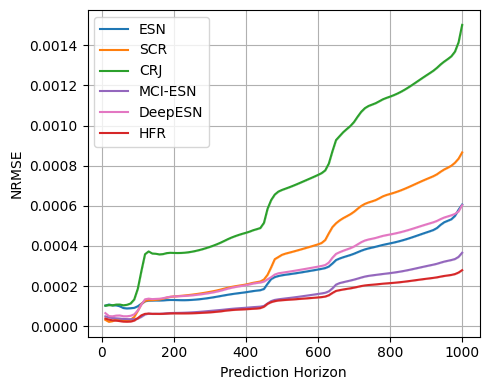

In [13]:
import os

# Save directory
base_dir = 'fig/'
os.makedirs(base_dir, exist_ok=True)
save_path = os.path.join(base_dir, "NRMSE_vs_Prediction_Horizon_AR_Rossler.png")

# Models and colors
model_names = ['ESN', 'SCR', 'CRJ', 'MCI-ESN', 'DeepESN', 'HFR']
model_colors = {
    'ESN': '#1f77b4',
    'SCR': '#ff7f0e',
    'CRJ': '#2ca02c',
    'MCI-ESN': '#9467bd',
    'DeepESN': '#e377c2',
    'HFR': '#d62728'
}

# Assumed all_horizons range (based on your example)
all_horizons = [str(h) for h in range(10, 1001, 10)]

# Plotting
plt.figure(figsize=(5, 4))

for model in model_names:
    mean_vals = []
    std_vals = []

    model_data = nrmse_dict.get(model, {})

    for horizon in all_horizons:
        val = model_data.get(horizon)

        if isinstance(val, list):  # multi-run
            all_vals = val
        elif val is not None:  # single-run
            all_vals = [val]
        else:
            all_vals = []

        if all_vals:
            mean_vals.append(np.mean(all_vals))
            std_vals.append(np.std(all_vals))
        else:
            mean_vals.append(np.nan)
            std_vals.append(np.nan)

    mean_vals = np.array(mean_vals)
    std_vals = np.array(std_vals)

    plt.plot([int(h) for h in all_horizons], mean_vals, label=model, color=model_colors[model])
    plt.fill_between([int(h) for h in all_horizons],
                     mean_vals - std_vals,
                     mean_vals + std_vals,
                     color=model_colors[model],
                     alpha=0.2)

# Labels and layout
plt.xlabel('Prediction Horizon')
plt.ylabel('NRMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and show
plt.savefig(save_path, dpi=250)
plt.show()


In [14]:
import pandas as pd

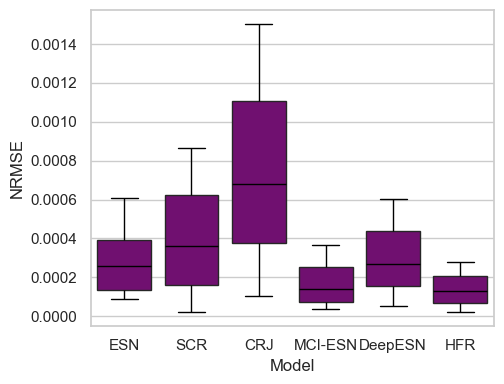

In [16]:
# Define where to save
boxplot_save_path = os.path.join(base_dir, "NRMSE_Boxplot_AR_Rossler.png")

# Shortlist of models and horizons
model_names = ['ESN', 'SCR', 'CRJ', 'MCI-ESN', 'DeepESN', 'HFR']
selected_horizons = all_horizons  # Assuming all_horizons is like this

# Flatten data
plot_data = []
for model in model_names:
    model_data = nrmse_dict.get(model, {})

    if isinstance(model_data, list):  # Multi-run: list of dicts
        for run_dict in model_data:
            for h in selected_horizons:
                if h in run_dict:
                    plot_data.append({'Model': model, 'Horizon': int(h), 'NRMSE': run_dict[h]})
    elif isinstance(model_data, dict):  # Single-run: one dict
        for h in selected_horizons:
            if h in model_data:
                plot_data.append({'Model': model, 'Horizon': int(h), 'NRMSE': model_data[h]})

# Convert to DataFrame
df = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(5.2, 4))
sns.set(style="whitegrid")

box = sns.boxplot(
    data=df,
    x='Model',
    y='NRMSE',
    color='#800080',  # solid dark purple
    showfliers=False
)

# Set white median lines and black outlines
for line in box.artists:
    line.set_edgecolor('black')
    line.set_facecolor('#800080')

for line in box.lines:
    line.set_color('black')  # whiskers

for i, artist in enumerate(box.artists):
    box.lines[i * 6 + 4].set_color('white')  # median line
    box.lines[i * 6 + 4].set_linewidth(2)

# Labels and save
plt.xlabel('Model')
plt.ylabel('NRMSE')
plt.tight_layout()
plt.savefig(boxplot_save_path, dpi=250)
plt.show()

In [17]:
hfr = HFRRes3D(
    cells_per_level=[5, 10, 15, 20, 25, 35, 45, 50, 95],
    spectral_radius=0.92,
    input_scale=0.1,
    leaking_rate=0.9,
    ridge_alpha=1e-8,
    seed=100
)
hfr.fit_readout(train_input, train_target, discard=100)
hfr_preds = hfr.predict_autoregressive(initial_input, num_steps)
# hfr_preds = hfr.predict_open_loop(test_input)

NameError: name 'HFRRes3D' is not defined

In [323]:
mci_esn = MCI3D(
    reservoir_size=300,
    cycle_weight=0.8,
    connect_weight=0.6,
    combine_factor=0.2,
    # spectral_radius=0.95,
    input_scale=0.2,
    leaking_rate=0.5,
    ridge_alpha=1e-7,
    seed=43
)
mci_esn.fit_readout(train_input, train_target, discard=100)
# mci_esn_preds = mci_esn.predict_autoregressive(initial_input, num_steps)
mci_esn_preds = mci_esn.predict_open_loop(test_input)

In [327]:
esn = SparseESN3D(
    reservoir_size=300,
    spectral_radius=0.9,
    connectivity=0.1,
    input_scale=1,
    leaking_rate=0.5,
    ridge_alpha=1e-7,
    seed=40
)
esn.fit_readout(train_input, train_target, discard=100)
# esn_preds = esn.predict_autoregressive(initial_input, num_steps)
esn_preds = esn.predict_open_loop(test_input)

In [393]:
model_preds = {
    # 'ESN': esn_preds,       # Vivid Blue
    # 'SCR': cycle_res_preds,       # Vivid Orange
    # 'CRJ': crj_preds,       # Bright Green
    # # 'SW-ESN': sw_esn_preds,    # Bold Red
    # 'MCI-ESN': mci_esn_preds,   # Vivid Purple
    # # 'ParallelESN': paraesn_preds,   # Warm Brown
    # 'DeepESN': deepesn_preds,    # Vibrant Pink
    'HFR': hfr_preds
}

In [394]:
model_colors = {
    # 'ESN': '#1f77b4',
    # 'SCR': '#ff7f0e',
    # 'CRJ': '#2ca02c',
    # # 'SW-ESN': '#d62728',
    # 'MCI-ESN': '#9467bd',
    # # 'ParallelESN': '#8c564b',
    # 'DeepESN': '#e377c2',
    'HFR': '#d62728'
}

In [395]:
# # Folder to save the plots
# save_folder = 'fig/'
# os.makedirs(save_folder, exist_ok=True)

# # Line styles and color map (true is always blue)
# true_color = '#1f77b1'

# # Compute PSD for the ground truth
# freqs_true, psd_true = compute_psd(test_target)

# # Loop through all models
# for model, preds in model_preds.items():
#     # Compute PSD for model predictions
#     freqs_model, psd_model = compute_psd(preds)

#     # Create the plot
#     plt.figure(figsize=(12, 6))
#     plt.semilogy(freqs_true, psd_true, label='True', linestyle='--', linewidth=1.5, color=true_color)
#     plt.semilogy(freqs_model, psd_model, label=model, linestyle='-', linewidth=1.5, color=model_colors[model], alpha=0.7)

#     # plt.title(f'PSD Comparison for {model} (Z-component)', fontsize=16, fontweight='bold')
#     plt.xlabel('Frequency (Hz)', fontsize=13)
#     plt.ylabel('Power Spectral Density', fontsize=13)
#     plt.legend(fontsize=12)
#     plt.grid(True, which='both', linestyle='--', alpha=0.5)

#     # Save the plot
#     save_path = os.path.join(save_folder, f"Plot_TF_{chosen_system}_{model}_PSD_Zcomponent.png")
#     plt.tight_layout()
#     plt.savefig(save_path, dpi=100, bbox_inches='tight')
#     plt.show()

#     print(f"PSD Plot for {model} saved at: {save_path}")


In [396]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import os

# # Set up seaborn style
# sns.set(style="whitegrid")
# plot_len = 1000
# steps = time_test[:plot_len]
# # Define the models and their colors
# model_colors = {
#     'ESN': '#1f77b4',       # Vivid Blue
#     'SCR': '#ff7f0e',       # Vivid Orange
#     'CRJ': '#2ca02c',       # Bright Green
#     'SW-ESN': '#d62728',    # Bold Red
#     'MCI-ESN': '#9467bd',   # Vivid Purple
#     'ParallelESN': '#8c564b',   # Warm Brown
#     'DeepESN': '#e377c2'    # Vibrant Pink
# }


# # Dimensions and plotting parameters
# dims = ['x(t)', 'y(t)', 'z(t)']
# line_styles = ['--', '-']
# line_labels = ['True', 'Predicted']

# # Create a save folder if not exists
# save_folder = 'fig/'
# os.makedirs(save_folder, exist_ok=True)

# # Loop over all models
# for model in model_colors.keys():
#     # Initialize figure for each model
#     fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

#     # Get the predictions for the current model (replace 'model_preds' with actual predictions for each model)
#     preds = model_preds[model]  # Make sure model_preds holds predictions for each model
#     model_color = model_colors[model]

#     # Loop through each dimension and plot the true vs predicted values
#     for i in range(3):
#         # Plot the true trajectory (dashed line)
#         axes[i].plot(steps, test_target[:plot_len, i], label=line_labels[0],
#                      linestyle=line_styles[0], linewidth=3, color='#1f77b4')  # True value in Vivid Blue
#         # Plot the predicted trajectory (solid line)
#         axes[i].plot(steps, preds[:plot_len, i], label=model,
#                      linestyle=line_styles[1], linewidth=3, color=model_color, alpha=0.8)

#         # Set y-axis labels and legend
#         axes[i].set_ylabel(dims[i], fontsize=14)
#         axes[i].legend(loc='upper right', fontsize=12, frameon=True)

#         # Set ticks and grid for readability
#         axes[i].tick_params(axis='both', which='major', labelsize=12)
#         axes[i].grid(True, linestyle='--', linewidth=0.8, alpha=0.4)

#     # Set the x-axis label for the bottom subplot
#     axes[-1].set_xlabel('Time', fontsize=14)

#     # Adjust layout and title for the current model
#     # fig.suptitle(f'Predicted vs True Trajectories for {model} (Autoregressive Forecasting)',
#                 #  fontsize=18, fontweight='bold', y=1.02)

#     # Save the plot in high resolution
#     save_path = os.path.join(save_folder, f"Plot_TF_{chosen_system}_{model}_Predicted_vs_True_Trajectories.png")
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig(save_path, dpi=600, bbox_inches='tight')

#     # Show the plot for each model
#     plt.show()

#     # Print the path to the saved figure for reference
#     print(f"Plot for {model} saved at: {save_path}")


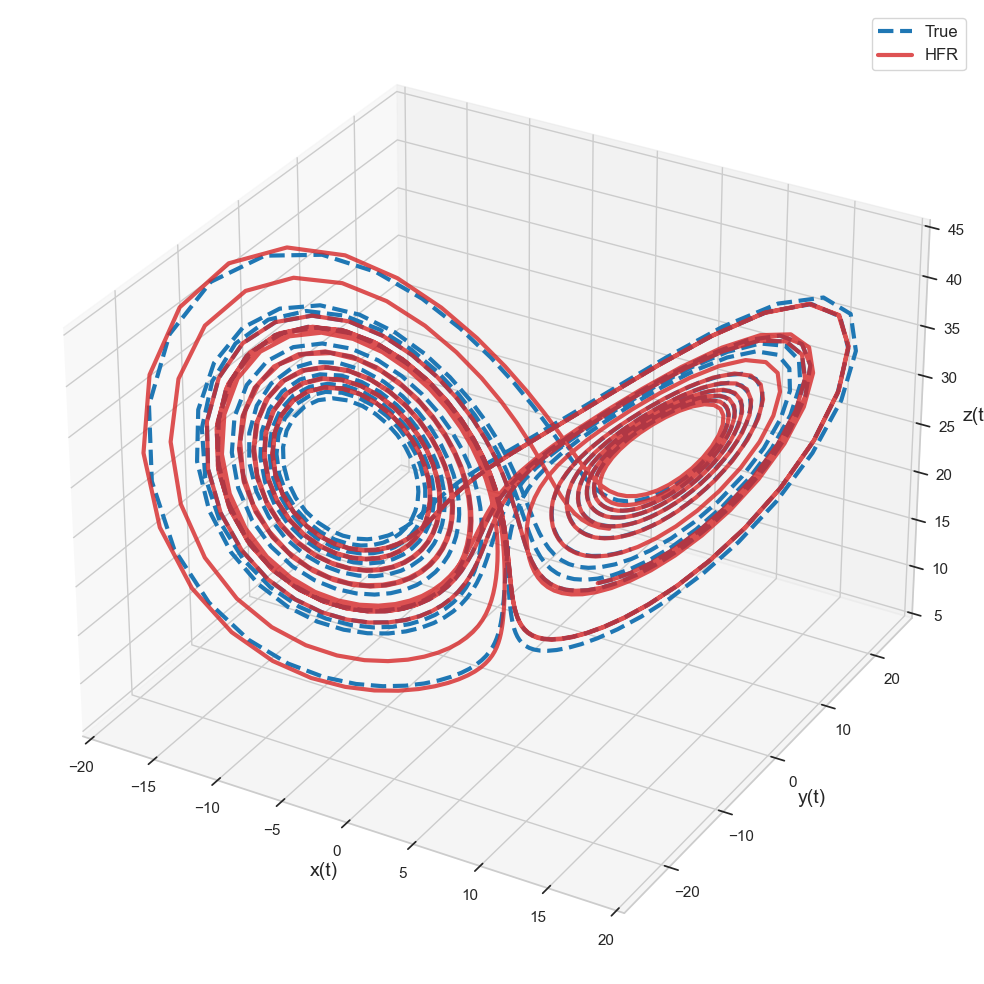

3D Phase Plot for HFR saved at: fig/Plot_TF_Lorenz_HFR_3D_Phase_Plot.png


In [405]:
# Set up seaborn style
sns.set(style="whitegrid")

# Create a save folder if not exists
save_folder = 'fig/'
os.makedirs(save_folder, exist_ok=True)

plot_len = 1000

# Loop over all models
for model in model_colors.keys():
    # Initialize 3D plot for each model
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get the predictions for the current model
    preds = model_preds[model]  # Make sure model_preds holds predictions for each model
    model_color = model_colors[model]

    # Plot the true trajectory (x(t), y(t), z(t)) in 3D
    ax.plot(test_target[:plot_len, 0], test_target[:plot_len, 1], test_target[:plot_len, 2],
            label='True', linestyle='--', linewidth=3, color='#1f77b4')  # True value in Vivid Blue

    # Plot the predicted trajectory (x(t), y(t), z(t)) in 3D
    ax.plot(preds[:plot_len, 0], preds[:plot_len, 1], preds[:plot_len, 2],
            label=model, linestyle='-', linewidth=3, color=model_color, alpha=0.8)

    # Set labels
    ax.set_xlabel('x(t)', fontsize=14)
    ax.set_ylabel('y(t)', fontsize=14)
    ax.set_zlabel('z(t)', fontsize=14)

    # Set the title for the plot
    # ax.set_title(f'Predicted vs True 3D Phase Plot for {model}', fontsize=18, fontweight='bold')

    # Add legend
    ax.legend(loc='upper right', fontsize=12, frameon=True)

    # Save the plot in high resolution
    save_path = os.path.join(save_folder, f"Plot_TF_{chosen_system}_{model}_3D_Phase_Plot.png")
    plt.tight_layout()
    plt.savefig(save_path, dpi=600, bbox_inches='tight')

    # Show the plot for each model
    plt.show()

    # Print the path to the saved figure for reference
    print(f"3D Phase Plot for {model} saved at: {save_path}")


# MIT-BIH Dataset

In [14]:
def create_delay_embedding(signal, embed_dim):
    L = len(signal) - embed_dim + 1
    emb = np.zeros((L, embed_dim))
    for i in range(L):
        emb[i, :] = signal[i:i+embed_dim]
    return emb

In [22]:
import wfdb

# Download and load record and annotations for patient #100
record = wfdb.rdrecord('100', sampfrom=0, sampto=25002, pn_dir='mitdb')  # first 20,000 samples
annotation = wfdb.rdann('100', 'atr', sampfrom=0, sampto=25002, pn_dir='mitdb')

In [23]:
# Get input signal u(t) from the first channel
u = record.p_signal[:, 0] 
u

array([-0.145, -0.145, -0.145, ..., -0.41 , -0.415, -0.425],
      shape=(25002,))

In [24]:
# Normalize input
u_min = np.min(u)
u_max = np.max(u)
u_norm = (u - u_min) / (u_max - u_min)

In [25]:
fs = record.fs  # sampling frequency (should be 360 Hz)
t_vals = np.arange(len(u_norm)) / fs

In [26]:
emb_dim = 3
# inputs = u_norm
inputs = create_delay_embedding(u_norm, emb_dim)

# Create target array (heartbeat locations)
targets = np.zeros(len(u_norm))
targets[annotation.sample] = 1  # mark annotations as 1 (heartbeat)
targets = create_delay_embedding(targets, emb_dim)

In [27]:
data_size = len(inputs)
train_size = 15000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size+1:]
test_target = targets[train_size+1:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 25000, train size: 15000, test size: 9999


In [28]:
horizons = [250, 500, 750, 1000]


nrmse_dict = defaultdict(list)
seeds = range(995, 1025)


for seed in seeds:
    esn = ESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        input_scale=0.5,
        leaking_rate=0.6,
        ridge_alpha=1e-7,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CR3D(
        reservoir_size=300,
        spectral_radius=0.8,
        input_scale=0.3,
        leaking_rate=0.7,
        ridge_alpha=1e-7,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

for seed in seeds:
    sparse = SparseESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        connectivity=0.08,
        input_scale=0.2,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        seed=seed
    )
    sparse.fit_readout(train_input, train_target, discard=5000)
    sparse_preds = sparse.predict_open_loop(test_input)
    sparse_nrmse = evaluate_nrmse(sparse_preds, test_target, horizons)
    nrmse_dict['Sparse-ESN'].append(sparse_nrmse)


for seed in seeds:
    crj = CRJ3D(
        reservoir_size=300,
        jump=20,
        spectral_radius=0.92,
        input_scale=0.6,
        leaking_rate=0.4,
        ridge_alpha=1e-7,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


for seed in seeds:
    sws_esn = SW3DSegregated(
        reservoir_size=300,
        edges_per_node=2,
        input_scale=0.4,
        rewiring_probability=1,
        spectral_radius=0.8,
        seed=seed
    )
    sws_esn.fit_readout(train_input, train_target, discard=5000)
    sws_esn_preds = sws_esn.predict_open(test_input)
    sws_esn_nrmse = evaluate_nrmse(sws_esn_preds, test_target, horizons)
    nrmse_dict['SWS-ESN'].append(sws_esn_nrmse)

for seed in seeds:
    swr_esn = SW3DRandom(
        reservoir_size=300,
        edges_per_node=4,
        input_scale=0.2,
        rewiring_probability=0.2,
        spectral_radius=0.8,
        seed=seed
    )
    swr_esn.fit_readout(train_input, train_target, discard=5000)
    swr_esn_preds = swr_esn.predict_open(test_input)
    swr_esn_nrmse = evaluate_nrmse(swr_esn_preds, test_target, horizons)
    nrmse_dict['SWR-ESN'].append(swr_esn_nrmse)


for seed in seeds:
    mci_esn = MCI3D(
        reservoir_size=300,
        cycle_weight=0.6,
        connect_weight=1,
        input_scale=0.5,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        combine_factor=0.3,
        seed=seed,
        v1=0.4, v2=0.4
    )
    mci_esn.fit_readout(train_input, train_target, discard=5000)
    mci_esn_preds = mci_esn.predict_open_loop(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    hfr = HFRRes3D(
        n_levels=8,      
        cells_per_level=[5, 15, 25, 30, 35, 40, 45, 105],
        spectral_radius=0.9,
        input_scale=0.2,
        leaking_rate=0.9,
        ridge_alpha=1e-8,
        seed=seed
    )
    hfr.fit_readout(train_input, train_target, discard=5000)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

KeyboardInterrupt: 

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'Sparse-ESN':<17} {'CRJ':<17} {'SWS-ESN':<17} {'SWR-ESN':<17} {'MCI-ESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sws_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SWS-ESN']]
    swr_vals  = [np.mean(swr_esn_nrmse[horizon]) for swr_esn_nrmse in nrmse_dict['SWR-ESN']]
    sparse_vals = [np.mean(sparse_nrmse[horizon]) for sparse_nrmse in nrmse_dict['Sparse-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, sparse_vals, crj_vals, sws_vals, swr_vals, mci_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
1000       1.4987 ± 0.2916   1.3069 ± 0.1143   1.2053 ± 0.1060   1.3972 ± 0.1451   1.1230 ± 0.0121   1.6553 ± 0.2547   0.7492 ± 0.1166   


# Sunspot Dataset

In [30]:
import pandas as pd
file_path = 'datasets/monthly-sunspots.csv'

df = pd.read_csv(file_path, sep=';', header = None)
df

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3310,2024,11,2024.873,152.5,20.9,681,0
3311,2024,12,2024.958,154.5,25.6,572,0
3312,2025,1,2025.042,137.0,23.3,670,0
3313,2025,2,2025.122,154.6,23.3,655,0


In [ ]:
data = df.iloc[:, 3].values
dt = 1
dataset_size = len(data)
data = create_delay_embedding(data, 3)
print(f"Dataset size: {dataset_size}")

# Train/Test Split
train_end = 2000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}\nTest size: {len(test_input)}")

Dataset size: 3315
Train size: 2000
Test size: 1312


In [ ]:
all_horizons = list(range(10, 1001, 10))

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)


for seed in seeds:
    esn = ESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        input_scale=0.5,
        leaking_rate=0.6,
        ridge_alpha=1e-7,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CR3D(
        reservoir_size=300,
        spectral_radius=0.8,
        input_scale=0.3,
        leaking_rate=0.7,
        ridge_alpha=1e-7,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

for seed in seeds:
    sparse = SparseESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        connectivity=0.08,
        input_scale=0.2,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        seed=seed
    )
    sparse.fit_readout(train_input, train_target, discard=100)
    sparse_preds = sparse.predict_open_loop(test_input)
    sparse_nrmse = evaluate_nrmse(sparse_preds, test_target, horizons)
    nrmse_dict['Sparse-ESN'].append(sparse_nrmse)


for seed in seeds:
    crj = CRJ3D(
        reservoir_size=300,
        jump=20,
        spectral_radius=0.92,
        input_scale=0.6,
        leaking_rate=0.4,
        ridge_alpha=1e-7,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


for seed in seeds:
    sws_esn = SW3DSegregated(
        reservoir_size=300,
        edges_per_node=2,
        input_scale=0.4,
        rewiring_probability=1,
        spectral_radius=0.8,
        seed=seed
    )
    sws_esn.fit_readout(train_input, train_target, discard=100)
    sws_esn_preds = sws_esn.predict_open(test_input)
    sws_esn_nrmse = evaluate_nrmse(sws_esn_preds, test_target, horizons)
    nrmse_dict['SWS-ESN'].append(sws_esn_nrmse)

for seed in seeds:
    swr_esn = SW3DRandom(
        reservoir_size=300,
        edges_per_node=4,
        input_scale=0.2,
        rewiring_probability=0.2,
        spectral_radius=0.8,
        seed=seed
    )
    swr_esn.fit_readout(train_input, train_target, discard=100)
    swr_esn_preds = swr_esn.predict_open(test_input)
    swr_esn_nrmse = evaluate_nrmse(swr_esn_preds, test_target, horizons)
    nrmse_dict['SWR-ESN'].append(swr_esn_nrmse)


for seed in seeds:
    mci_esn = MCI3D(
        reservoir_size=300,
        cycle_weight=0.6,
        connect_weight=1,
        input_scale=0.5,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        combine_factor=0.3,
        seed=seed,
        v1=0.4, v2=0.4
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict_open_loop(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    hfr = HFRRes3D(
        n_levels=8,      
        cells_per_level=[5, 15, 25, 30, 35, 40, 45, 105],
        spectral_radius=0.9,
        input_scale=0.2,
        leaking_rate=0.9,
        ridge_alpha=1e-8,
        seed=seed
    )
    hfr.fit_readout(train_input, train_target, discard=100)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

KeyboardInterrupt: 

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'Sparse-ESN':<17} {'CRJ':<17} {'SWS-ESN':<17} {'SWR-ESN':<17} {'MCI-ESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sws_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SWS-ESN']]
    swr_vals  = [np.mean(swr_esn_nrmse[horizon]) for swr_esn_nrmse in nrmse_dict['SWR-ESN']]
    sparse_vals = [np.mean(sparse_nrmse[horizon]) for sparse_nrmse in nrmse_dict['Sparse-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, sparse_vals, crj_vals, sws_vals, swr_vals, mci_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           HypER            
--------------------------------------------------------------------------------------------------------------------------------------------
200        5.1681 ± 2.5483   6.0723 ± 1.1326   4.8475 ± 1.4909   4.2787 ± 1.0273   2.4635 ± 0.1145   1.3174 ± 0.1826   0.8515 ± 0.1008   
400        5.0651 ± 1.3399   5.6918 ± 0.5887   4.2263 ± 1.2638   3.3983 ± 0.6059   2.0151 ± 0.0702   1.1023 ± 0.1138   0.6964 ± 0.0424   
600        4.7200 ± 1.0571   6.4209 ± 1.6932   4.0023 ± 0.6231   3.3421 ± 0.6611   1.8867 ± 0.0466   1.0375 ± 0.1171   0.6130 ± 0.0343   
800        4.1884 ± 0.9370   5.6912 ± 1.4899   3.5737 ± 0.5606   2.9863 ± 0.5822   1.9369 ± 0.0502   0.9951 ± 0.1003   0.6037

# Sante Fe Dataset

In [33]:
import pandas as pd

file_path = 'datasets/santa-fe-time-series-competition-data-set-b-1.0.0/b1.txt'

df = pd.read_csv(file_path, header=None, sep=' ')
df

,0,1,2,3
0,76.53,8320,7771,NaN
1,76.53,8117,7774,NaN
2,76.15,7620,7788,NaN
3,75.39,6413,7787,NaN
4,75.51,7518,7767,NaN
...,...,...,...,...
16995,73.57,16021,6498,NaN
16996,73.79,-6957,6547,NaN
16997,74.54,11476,6576,NaN
16998,74.36,15058,6573,NaN


In [ ]:
# Normalize the first column (column 0) of the DataFrame
df[0] = (df[0] - df[0].min()) / (df[0].max() - df[0].min())

In [ ]:
data = df.iloc[:7503, 0].values
chosen_system = "SantaFe"
dt = 1
T_data = len(data)
data = create_delay_embedding(data, 3)
print(f"Data length: {T_data}.")

# Train/Test Split
train_end = 10000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}  \nTest size: {len(test_input)}")


In [ ]:
# all_horizons = list(range(10, 1001, 10))

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)


for seed in seeds:
    esn = ESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        input_scale=0.5,
        leaking_rate=0.6,
        ridge_alpha=1e-7,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CR3D(
        reservoir_size=300,
        spectral_radius=0.8,
        input_scale=0.3,
        leaking_rate=0.7,
        ridge_alpha=1e-7,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

for seed in seeds:
    sparse = SparseESN3D(
        reservoir_size=300,
        spectral_radius=0.9,
        connectivity=0.08,
        input_scale=0.2,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        seed=seed
    )
    sparse.fit_readout(train_input, train_target, discard=5000)
    sparse_preds = sparse.predict_open_loop(test_input)
    sparse_nrmse = evaluate_nrmse(sparse_preds, test_target, horizons)
    nrmse_dict['Sparse-ESN'].append(sparse_nrmse)


for seed in seeds:
    crj = CRJ3D(
        reservoir_size=300,
        jump=20,
        spectral_radius=0.92,
        input_scale=0.6,
        leaking_rate=0.4,
        ridge_alpha=1e-7,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


for seed in seeds:
    sws_esn = SW3DSegregated(
        reservoir_size=300,
        edges_per_node=2,
        input_scale=0.4,
        rewiring_probability=1,
        spectral_radius=0.8,
        seed=seed
    )
    sws_esn.fit_readout(train_input, train_target, discard=5000)
    sws_esn_preds = sws_esn.predict_open(test_input)
    sws_esn_nrmse = evaluate_nrmse(sws_esn_preds, test_target, horizons)
    nrmse_dict['SWS-ESN'].append(sws_esn_nrmse)

for seed in seeds:
    swr_esn = SW3DRandom(
        reservoir_size=300,
        edges_per_node=4,
        input_scale=0.2,
        rewiring_probability=0.2,
        spectral_radius=0.8,
        seed=seed
    )
    swr_esn.fit_readout(train_input, train_target, discard=5000)
    swr_esn_preds = swr_esn.predict_open(test_input)
    swr_esn_nrmse = evaluate_nrmse(swr_esn_preds, test_target, horizons)
    nrmse_dict['SWR-ESN'].append(swr_esn_nrmse)


for seed in seeds:
    mci_esn = MCI3D(
        reservoir_size=300,
        cycle_weight=0.6,
        connect_weight=1,
        input_scale=0.5,
        leaking_rate=0.5,
        ridge_alpha=1e-7,
        combine_factor=0.3,
        seed=seed,
        v1=0.4, v2=0.4
    )
    mci_esn.fit_readout(train_input, train_target, discard=5000)
    mci_esn_preds = mci_esn.predict_open_loop(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    hfr = HFRRes3D(
        n_levels=8,      
        cells_per_level=[5, 15, 25, 30, 35, 40, 45, 105],
        spectral_radius=0.9,
        input_scale=0.2,
        leaking_rate=0.9,
        ridge_alpha=1e-8,
        seed=seed
    )
    hfr.fit_readout(train_input, train_target, discard=5000)
    hfr_preds = hfr.predict_open_loop(test_input)
    hfr_nrmse = evaluate_nrmse(hfr_preds, test_target, horizons)
    nrmse_dict['HFR'].append(hfr_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'Sparse-ESN':<17} {'CRJ':<17} {'SWS-ESN':<17} {'SWR-ESN':<17} {'MCI-ESN':<17} {'HFR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sws_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SWS-ESN']]
    swr_vals  = [np.mean(swr_esn_nrmse[horizon]) for swr_esn_nrmse in nrmse_dict['SWR-ESN']]
    sparse_vals = [np.mean(sparse_nrmse[horizon]) for sparse_nrmse in nrmse_dict['Sparse-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, sparse_vals, crj_vals, sws_vals, swr_vals, mci_vals, hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()